In [61]:
import datetime as dt
from dateutil.relativedelta import relativedelta
import yfinance as yf  
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pandas.tseries.holiday import USFederalHolidayCalendar
import datetime
import holidays
from statsmodels.tsa.stattools import adfuller
from dtaidistance import preprocessing
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.utilities.dataframe_functions import impute
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import silhouette_score
from tslearn.metrics import dtw as ts_dtw, cdist_dtw
from tslearn.barycenters import dtw_barycenter_averaging
from sklearn.metrics import silhouette_score as sklearn_silhouette, calinski_harabasz_score, davies_bouldin_score
from pandas import option_context
import warnings
import itertools

### Draw Data from CSV

In [62]:
data = pd.read_csv('SP500_Hourly_102Weeks_2024_01_14.csv', index_col=0, parse_dates=True)  
data.index = pd.to_datetime(data.index, utc=True).tz_convert('America/New_York')
data.head(10)

Open         High          Low        Close  \
Datetime                                                                        
2022-01-31 09:30:00-05:00  4431.790039  4472.020020  4414.020020  4458.209961   
2022-01-31 10:30:00-05:00  4458.339844  4468.830078  4452.740234  4455.779785   
2022-01-31 11:30:00-05:00  4456.299805  4483.180176  4453.419922  4477.540039   
2022-01-31 12:30:00-05:00  4477.490234  4489.350098  4473.399902  4482.819824   
2022-01-31 13:30:00-05:00  4482.890137  4497.709961  4479.939941  4497.709961   
2022-01-31 14:30:00-05:00  4497.750000  4497.930176  4471.459961  4486.180176   
2022-01-31 15:30:00-05:00  4486.189941  4516.890137  4482.020020  4515.439941   
2022-02-01 09:30:00-05:00  4519.569824  4525.560059  4483.529785  4501.950195   
2022-02-01 10:30:00-05:00  4501.970215  4522.270020  4493.779785  4512.879883   
2022-02-01 11:30:00-05:00  4512.919922  4523.939941  4504.540039  4514.740234   

                             Adj Close     Volume  
Datetime                                           
2022-01-31 09:30:00-05:00  4458.209961          0  
2022-01-31 10:30:00-05:00  4455.779785  310320785  
2022-01-31 11:30:00-05:00  4477.540039  259708983  
2022-01-31 12:30:00-05:00  4482.819824  237902000  
2022-01-31 13:30:00-05:00  4497.709961  218623000  
2022-01-31 14:30:00-05:00  4486.180176  291230000  
2022-01-31 15:30:00-05:00  4515.439941  464471000  
2022-02-01 09:30:00-05:00  4501.950195          0  
2022-02-01 10:30:00-05:00  4512.879883  349426580  
2022-02-01 11:30:00-05:00  4514.740234  261984302

In [63]:
df = pd.DataFrame(data.Close)
display(df)

Close
Datetime                              
2022-01-31 09:30:00-05:00  4458.209961
2022-01-31 10:30:00-05:00  4455.779785
2022-01-31 11:30:00-05:00  4477.540039
2022-01-31 12:30:00-05:00  4482.819824
2022-01-31 13:30:00-05:00  4497.709961
...                                ...
2024-01-19 11:30:00-05:00  4809.129883
2024-01-19 12:30:00-05:00  4825.220215
2024-01-19 13:30:00-05:00  4835.379883
2024-01-19 14:30:00-05:00  4836.979980
2024-01-19 15:30:00-05:00  4838.959961

[3453 rows x 1 columns]

### Pre-Processing

#### Train-Test Split

In [64]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits 

In [65]:
tscv = TimeBasedCV(train_period=78,
                   test_period=6,
                   freq='weeks')

for train_index, test_index in tscv.split(df.reset_index(),
#                    validation_split_date=datetime.date(2019,2,1),
                                          date_column='Datetime'):
    print(f"train_index: {train_index}")
    print(f"test_index: {test_index}")

# get number of splits
tscv.get_n_splits()

Train period: 2022-01-31 - 2023-07-31 , Test period 2023-07-31 - 2023-09-11 # train records 2617 , # test records 203
Train period: 2022-03-14 - 2023-09-11 , Test period 2023-09-11 - 2023-10-23 # train records 2617 , # test records 210
Train period: 2022-04-25 - 2023-10-23 , Test period 2023-10-23 - 2023-12-04 # train records 2624 , # test records 199
Train period: 2022-06-06 - 2023-12-04 , Test period 2023-12-04 - 2024-01-15 # train records 2620 , # test records 196
train_index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,

4

#### Prepare DataFrame for tsfresh

In [66]:
def process_data(train_df, test_df, single_length=True):
    train_grp_df = train_df.groupby(pd.Grouper(freq='W'))
    test_grp_df = test_df.groupby(pd.Grouper(freq='W'))
    
    train_combined_series = []
    train_combined_df = []
    test_combined_series = []
    test_combined_df = []
    
    if single_length:
        min_length = float('inf')

        for key, item in train_grp_df:
            item = train_grp_df.get_group(key)
            series = item.Close.to_numpy()
            min_length = min(min_length, series.shape[0])
            train_combined_series.append(series)
            
        for key, item in test_grp_df:
            item = test_grp_df.get_group(key)
            series = item.Close.to_numpy()
            min_length = min(min_length, series.shape[0])
            test_combined_series.append(series)

        for week_idx, series in enumerate(train_combined_series):
            series_normalized = rescale_data(resample_data(series, min_length)).reshape(min_length)
            week_df = pd.DataFrame(series_normalized)
    #         week_df['Datetime'] = item.index
            week_df['week'] = week_idx
    #         week_df.columns = ['Close', 'Datetime', 'Week']
            week_df.columns = ['Close', 'Week']
            train_combined_df.append(week_df)
            
        for week_idx, series in enumerate(test_combined_series):
            series_normalized = rescale_data(resample_data(series, min_length)).reshape(min_length)
            week_df = pd.DataFrame(series_normalized)
    #         week_df['Datetime'] = item.index
            week_df['week'] = week_idx
    #         week_df.columns = ['Close', 'Datetime', 'Week']
            week_df.columns = ['Close', 'Week']
            test_combined_df.append(week_df)
    
# Allow different length of series
#     for week_idx, key in enumerate(grp_df.groups.keys()):
#         item = grp_df.get_group(key)
#         series = item.Close.to_numpy()
#         series_rescaled = rescale_data(series.reshape(-1, 1))
#         week_df = pd.DataFrame(series)
#         week_df['Datetime'] = item.index
#         week_df['week'] = week_idx
#         week_df.columns = ['Close', 'Datetime', 'Week']
#         combined_df.append(week_df)
        
    return pd.concat(train_combined_df), pd.concat(test_combined_df)

def resample_data(df, length):
    Resampler = TimeSeriesResampler(sz=length)
    return Resampler.fit_transform(df)

def rescale_data(df):
    # Default mean = 0, std = 1
    Scaler = TimeSeriesScalerMeanVariance()
    return Scaler.fit_transform(df)

#### Analyze PCA plot and cluster results for a single iteration of Train-Test-Split

In [67]:
def generate_train_test_splits(df):
    datasets = []
    df = df.reset_index()
    
    tscv = TimeBasedCV(train_period=78, test_period=6, freq='weeks')
    
    for train_index, test_index in tscv.split(df, date_column='Datetime'):
        X_train_full = df.loc[train_index]
        X_train_full.set_index("Datetime", inplace = True)
        X_test_full = df.loc[test_index]
        X_test_full.set_index("Datetime", inplace = True)
        X_train, X_test = process_data(X_train_full, X_test_full)

        datasets.append([X_train, X_test])
        
    return datasets

#### Analyzing the third train-test period

In [68]:
# Deeper analysis on the ith train test set
train_df_3, test_df_3 = generate_train_test_splits(df)[2]

Train period: 2022-01-31 - 2023-07-31 , Test period 2023-07-31 - 2023-09-11 # train records 2617 , # test records 203
Train period: 2022-03-14 - 2023-09-11 , Test period 2023-09-11 - 2023-10-23 # train records 2617 , # test records 210
Train period: 2022-04-25 - 2023-10-23 , Test period 2023-10-23 - 2023-12-04 # train records 2624 , # test records 199
Train period: 2022-06-06 - 2023-12-04 , Test period 2023-12-04 - 2024-01-15 # train records 2620 , # test records 196


In [69]:
def tsfresh_extract_features(df):
    X_extracted = extract_features(df, column_id='Week', impute_function=impute,
#                                           default_fc_parameters=MinimalFCParameters()
                                         )
    
    display(X_extracted)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X_extracted)
    
    return scaled_data, X_extracted

In [70]:
formatted_data, extracted_data = tsfresh_extract_features(train_df_3)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 39/39 [00:06<00:00,  5.86it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                              1.0                       0.0   
1                                              1.0                       0.0   
2                                              0.0                       0.0   
3                                              1.0                       0.0   
4                                              0.0                       0.0   
..                                             ...                       ...   
73                                             1.0                       0.0   
74                                             0.0                       0.0   
75                                             1.0                       0.0   
76                                             0.0                       0.0   
77                                             0.0                       0.0   

    Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                        0.0                   0.0       5.018208e-13   
1                        0.0                   0.0      -8.615331e-14   
2                        0.0                   0.0       6.150636e-14   
3                        0.0                   0.0      -1.709743e-13   
4                        0.0                   0.0       1.256772e-13   
..                       ...                   ...                ...   
73                       0.0                   0.0       4.853895e-13   
74                       0.0                   0.0      -5.715428e-13   
75                       0.0                   0.0      -3.033129e-13   
76                       0.0                   0.0      -3.130829e-13   
77                       0.0                   0.0       4.440892e-16   

    Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0                24.0                0.621284           -0.117071   
1                24.0                0.592768           -0.033562   
2                24.0                0.484463           -0.010443   
3                24.0                0.302137           -0.068818   
4                24.0                0.247025            0.117478   
..                ...                     ...                 ...   
73               24.0                0.227151           -0.113128   
74               24.0                0.474234           -0.044379   
75               24.0                0.511423            0.042324   
76               24.0                0.468057            0.059283   
77               24.0                0.230265           -0.124036   

    Close__mean_second_derivative_central  Close__median  ...  \
0                               -0.010043       0.013040  ...   
1                                0.033783       0.024077  ...   
2                                0.011137       0.481173  ...   
3                                0.022547      -0.138479  ...   
4                               -0.001461      -0.464381  ...   
..                                    ...            ...  ...   
73                              -0.011214       0.457230  ...   
74                              -0.014185      -0.224917  ...   
75                              -0.012517      -0.187153  ...   
76                              -0.003001       0.293475  ...   
77                              -0.007623       0.234123  ...   

    Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                         1.072017                         1.285293   
1                         1.072017                         1.418069   
2                         0.687092                         1.178655   
3                         0.535961                         0.535961   
4                         0.271189                         0.535961   
..                             ...                              ...   
73                        0.535961                         

In [71]:
def plot_pca_components(data):    
    # Visualize how many components to use in PCA
    pca = PCA()
    pca.fit(data)
    plt.figure(figsize=(20,10))
    plt.grid()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')

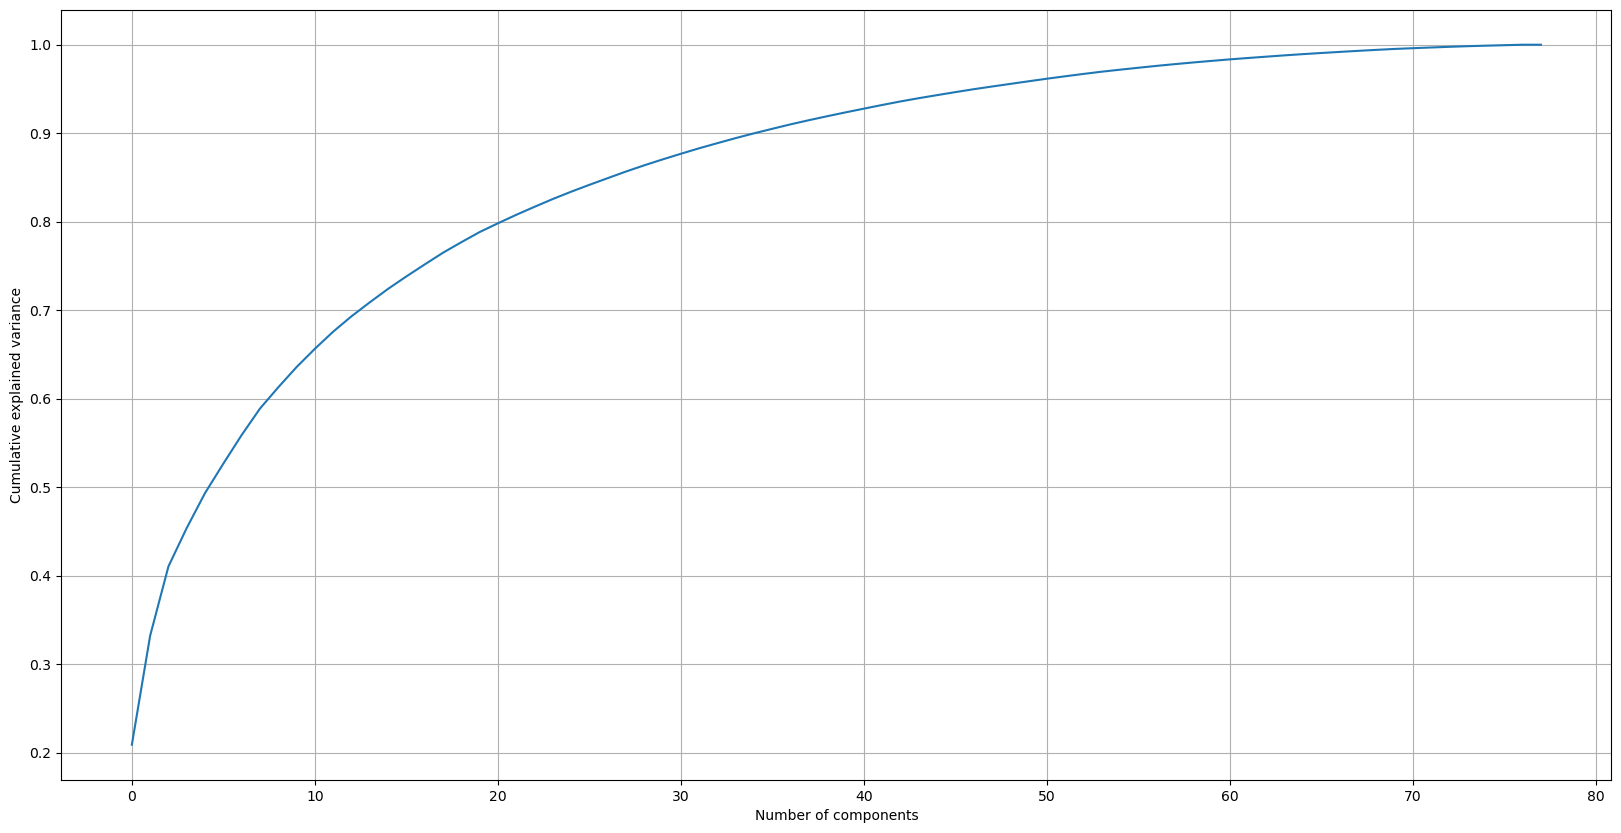

In [72]:
plot_pca_components(formatted_data)

In [73]:
def plot_pca_3components(component_data, column_names):

    df_components = pd.DataFrame(component_data, index=['PC1', 'PC2', 'PC3'])
    print("Principal Component Values")
    display(df_components)
    
#     num = len(component_data)
#     for i in range(num):
        
        
#         plt.plot(component_data[i])
#         plt.title(f'PC{i+1}')

    df_components_transposed = df_components.T
    
    fig = px.line(df_components_transposed, color_discrete_sequence= ['dodgerblue', 'orange', 'seagreen'])

    fig.update_layout(title='Sensitivity of different time series characteristics to each PC',
                      yaxis_title='Loading (sensitivity)',
                      xaxis_title='TSFresh Extracted Time Series Characteristics',
                      width = 1000,
                      plot_bgcolor='white'
                     )
    
    fig.update_xaxes(
            mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        gridcolor='lightgrey',
    )

    fig.update_yaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        gridcolor='lightgrey'
    )

    fig.show()
    
    # Display top N components for each PC
    print('Displaying Top N features based on sensitivity for each PC')
    N = 3
    topN_components = df_components.apply(lambda x: [column_names[i] for i in x.nlargest(N).index.values], axis=1)
    with option_context('display.max_colwidth', 400):
        display(pd.DataFrame(topN_components.to_list(), index=topN_components.index, columns=[f'Top {i} Feature' for i in range(1, N+1)]))
    

In [74]:
def calculate_plot_wcss(pca_data_train, min_clusters, max_clusters):
    # Ignore memory leak warning for Kmeans
    warnings.filterwarnings('ignore')

    wcss = []
    models = []

    # Seed is standardized across all experiemends
    seed = 0
    for i in range(min_clusters, max_clusters + 1):
        km = KMeans(n_clusters=i, max_iter=10, n_init=2, random_state=seed) 
        km.fit(pca_data_train)
        models.append(km)
        wcss.append(km.inertia_)

    plt.figure(figsize=(12,6))
    plt.grid()
    plt.plot(range(min_clusters,  max_clusters + 1), wcss,marker='o', linestyle='--')
    plt.xticks(range(min_clusters,  max_clusters + 1))
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()
    
    return models, wcss

%Variance  %CumulativeVariance
PC1  20.886863            20.886863
PC2  12.326351            33.213215
PC3   7.830315            41.043529

Principal Component Values


0             1             2             3         4    \
PC1 -0.027094  1.110223e-16  0.000000e+00 -2.775558e-17 -0.004591   
PC2 -0.008502 -8.326673e-17  4.440892e-16 -4.996004e-16  0.010396   
PC3  0.022024  1.144917e-16 -1.387779e-17  5.551115e-17 -0.020787   

              5         6         7         8         9    ...       773  \
PC1 -4.922278e-17 -0.052042  0.104194 -0.012147 -0.029346  ... -0.058326   
PC2  1.526557e-16  0.127363  0.036815  0.004038 -0.041189  ...  0.095277   
PC3  7.771561e-16 -0.009775 -0.019493 -0.005483 -0.102244  ...  0.011915   

          774       775       776       777       778       779       780  \
PC1 -0.043682 -0.051998 -0.038614 -0.043565 -0.053187 -0.048361 -0.046652   
PC2  0.101751  0.084362  0.047289  0.055167  0.051866  0.050673  0.039459   
PC3 -0.005868  0.002998 -0.003248 -0.008500 -0.008959 -0.004025 -0.012605   

     781       782  
PC1  0.0 -0.027793  
PC2 -0.0  0.059496  
PC3 -0.0  0.011470  

[3 rows x 783 columns]

Displaying Top N features based on sensitivity for each PC


Top 1 Feature  \
PC1  Close__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"   
PC2                                    Close__absolute_sum_of_changes   
PC3                      Close__fft_coefficient__attr_"real"__coeff_1   

                                                         Top 2 Feature  \
PC1   Close__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"   
PC2  Close__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0   
PC3       Close__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)   

                                                    Top 3 Feature  
PC1                             Close__linear_trend__attr_"slope"  
PC2                                        Close__mean_abs_change  
PC3  Close__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)

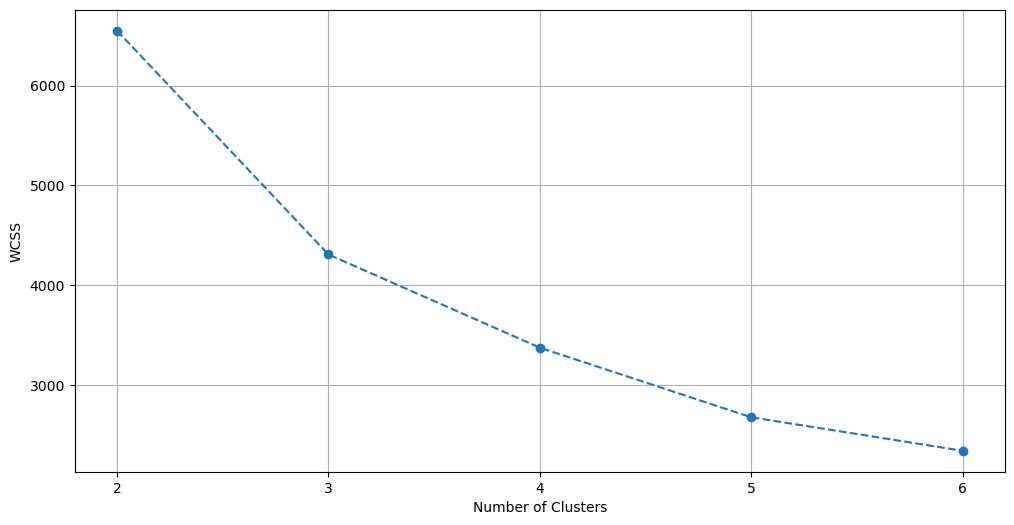

In [75]:
optimal_pca = PCA(n_components=3, svd_solver='full')
pca_data_train = optimal_pca.fit_transform(formatted_data)

# Display Variance Ratio and PCA Sensitivity for 3 PCs
df_variance_ratio = pd.DataFrame(np.array([optimal_pca.explained_variance_ratio_ * 100, optimal_pca.explained_variance_ratio_.cumsum() * 100]).transpose(), columns=['%Variance', '%CumulativeVariance'], index=['PC1', 'PC2', 'PC3'])
display(df_variance_ratio)

plot_pca_3components(optimal_pca.components_, extracted_data.columns)


min_clusters = 2
max_clusters = 6   
    
models, wcss = calculate_plot_wcss(pca_data_train, min_clusters, max_clusters)

In [76]:
def determine_optimal_k_wcss(wcss, max_clusters):
    wcss = np.array(wcss)
    k_range = range(2, max_clusters + 1)
    slope = (wcss[0] - wcss[-1]) / (k_range[0] - k_range[-1])
    intercept = wcss[0] - slope * k_range[0]
    y = k_range * slope + intercept
    optimal_k = k_range[(y - wcss).argmax()]
    return optimal_k

In [77]:
optimal_k = determine_optimal_k_wcss(wcss, max_clusters)
optimal_k

3

In [78]:
km = models[determine_optimal_k_wcss(wcss, max_clusters) - min_clusters]
km

KMeans(max_iter=10, n_clusters=3, n_init=2, random_state=0)

In [79]:
y_pred_train = km.labels_

y_pred_train

array([0, 0, 2, 2, 1, 0, 2, 2, 1, 2, 1, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 2,
       0, 0, 0, 0, 1, 2, 1, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2, 1, 1, 0, 2, 2,
       1, 2, 0, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 1, 0, 1, 2, 1, 2, 1, 0, 0,
       2, 0, 2, 0, 1, 2, 0, 2, 0, 1, 0, 2])

In [80]:
formatted_data, extracted_data = tsfresh_extract_features(test_df_3)

pca_data_test = optimal_pca.transform(formatted_data)

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.63it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   
5                                             0.0                       0.0   

   Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                       0.0                   0.0       7.904788e-14   
1                       0.0                   0.0       1.394440e-13   
2                       0.0                   0.0      -7.256418e-13   
3                       0.0                   0.0      -2.398082e-14   
4                       0.0                   1.0       4.440892e-16   
5                       0.0                   0.0       7.416290e-13   

   Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0               24.0                0.279414           -0.096743   
1               24.0                0.137773            0.121247   
2               24.0                0.504203            0.139814   
3               24.0                0.250941            0.127150   
4               24.0                0.413249            0.110330   
5               24.0                0.397261            0.123295   

   Close__mean_second_derivative_central  Close__median  ...  \
0                              -0.005585       0.134211  ...   
1                              -0.003016      -0.382016  ...   
2                               0.008562       0.091803  ...   
3                              -0.009858       0.460718  ...   
4                              -0.016155       0.081939  ...   
5                              -0.001317      -0.254585  ...   

   Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                        0.535961                         0.535961   
1                        0.271189                         0.535961   
2                        0.937156                         1.410514   
3                        0.793730                         0.793730   
4                        0.535961                         0.535961   
5                        0.830518                         1.303876   

   Close__fourier_entropy__bins_100  \
0                          1.178655   
1                          1.178655   
2                          2.351673   
3                          1.839297   
4                          1.732659   
5                          2.138397   

   Close__permutation_entropy__dimension_3__tau_1  \
0                                        1.657180   
1                                        0.838728   
2                                        1.567236   
3                                        1.606466   
4                                        1.538260   
5                                        1.540306   

   Close__permutation_entropy__dimension_4__tau_1  \
0                                        2.293452   
1                                        1.219137   
2                                        2.425480   
3                                        2.306336   
4                                        2.133211   
5                                        2.136507   

   Close__permutation_entropy__dimension_5__tau_1  \
0                                        2.718473   
1                                        1.607575   
2                                        2.787788   
3                                        2.649159   
4                                        2.622996   
5                                        2.510529   

   Close__permutation_entropy__dimension_6__tau_1  \
0                                        2.871476   
1                              

In [81]:
y_pred_test = km.predict(pca_data_test)

y_pred_test

array([2, 1, 0, 0, 0, 0])

In [82]:
def plot_pca_clusters_2d(model, pca_data):
    
    for cluster in range(model.n_clusters):
#         cluster_points = pca_data[model.labels_ == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

    # Plot the cluster centroids as black 'X' markers
    ax.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1],
                color='black', marker='x', label='Centroids')

    plt.title("Clusters in PCA Space")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_box_aspect(None, zoom=0.90)
    plt.legend()

    # Display the plot
    plt.show()
    
def plot_pca_clusters_3d(model, pca_data):
    
    # Prepare 3D graph
    fig = plt.figure(figsize=(12, 9), constrained_layout=True)
    ax = plt.axes(projection='3d')
    
    for cluster in range(model.n_clusters):
        cluster_points = pca_data[model.labels_ == cluster]
        # Plot 3D plot
        ax.scatter3D(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f"Cluster {cluster}")

    # Plot the cluster centroids as black 'X' markers
    ax.scatter3D(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], model.cluster_centers_[:, 2],
                color='black', marker='x', label='Centroids')

    plt.title("Clusters in PCA Space")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3", rotation=90)
    ax.set_box_aspect(None, zoom=0.90)
    ax.legend(labels=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Centroids'])

    # Display the plot
    plt.show()

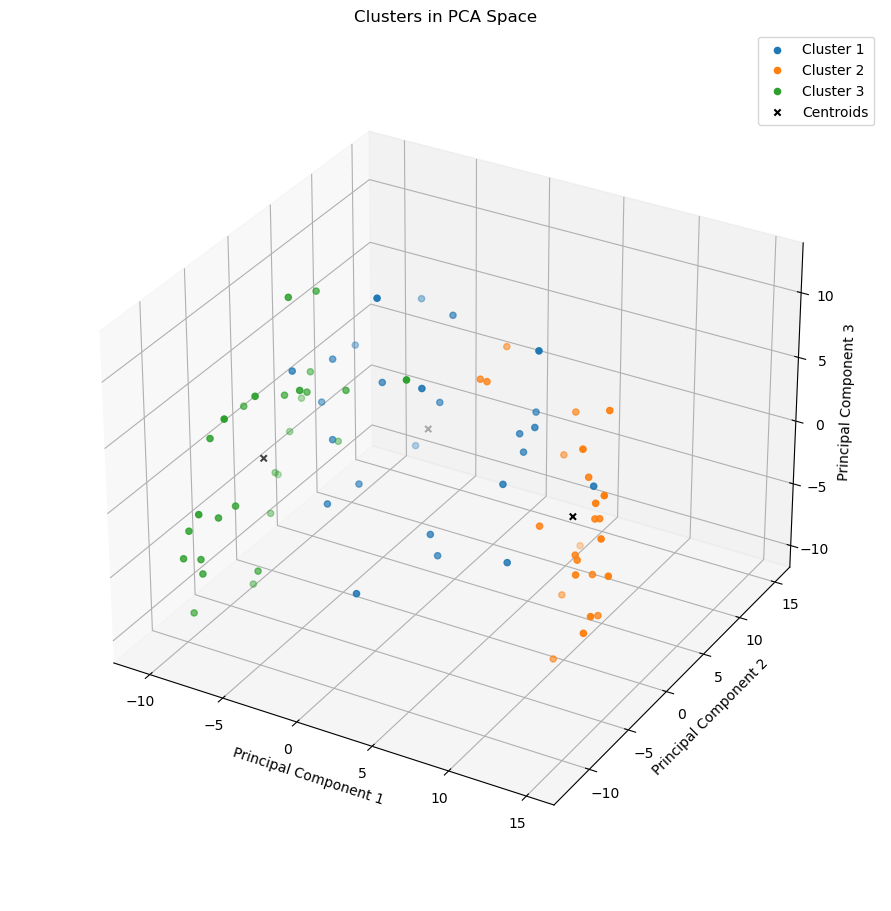

In [83]:
plot_pca_clusters_3d(km, pca_data_train)

#### Analyzing the fourth train test period

In [84]:
# Deeper analysis on the ith train test set
train_df_4, test_df_4 = generate_train_test_splits(df)[3]

Train period: 2022-01-31 - 2023-07-31 , Test period 2023-07-31 - 2023-09-11 # train records 2617 , # test records 203
Train period: 2022-03-14 - 2023-09-11 , Test period 2023-09-11 - 2023-10-23 # train records 2617 , # test records 210
Train period: 2022-04-25 - 2023-10-23 , Test period 2023-10-23 - 2023-12-04 # train records 2624 , # test records 199
Train period: 2022-06-06 - 2023-12-04 , Test period 2023-12-04 - 2024-01-15 # train records 2620 , # test records 196


In [85]:
formatted_data, extracted_data = tsfresh_extract_features(train_df_4)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  9.33it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                              1.0                       0.0   
1                                              1.0                       0.0   
2                                              0.0                       0.0   
3                                              1.0                       0.0   
4                                              0.0                       0.0   
..                                             ...                       ...   
73                                             0.0                       0.0   
74                                             0.0                       0.0   
75                                             0.0                       0.0   
76                                             0.0                       0.0   
77                                             0.0                       0.0   

    Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                        0.0                   0.0       1.896261e-13   
1                        0.0                   0.0       1.394440e-13   
2                        0.0                   0.0       3.246292e-13   
3                        0.0                   0.0      -1.743050e-13   
4                        0.0                   0.0      -3.641532e-14   
..                       ...                   ...                ...   
73                       0.0                   0.0       1.394440e-13   
74                       0.0                   0.0      -7.256418e-13   
75                       0.0                   0.0      -2.398082e-14   
76                       0.0                   1.0       4.440892e-16   
77                       0.0                   0.0       7.416290e-13   

    Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0                24.0                0.201673           -0.129051   
1                24.0                0.433708           -0.094681   
2                24.0                0.227536            0.122829   
3                24.0                0.323063           -0.068031   
4                24.0                0.222375            0.127096   
..                ...                     ...                 ...   
73               24.0                0.137773            0.121247   
74               24.0                0.504203            0.139814   
75               24.0                0.250941            0.127150   
76               24.0                0.413249            0.110330   
77               24.0                0.397261            0.123295   

    Close__mean_second_derivative_central  Close__median  ...  \
0                                0.002027       0.464347  ...   
1                               -0.014649       0.243460  ...   
2                                0.007731      -0.468421  ...   
3                               -0.000576      -0.196351  ...   
4                               -0.003530       0.309669  ...   
..                                    ...            ...  ...   
73                              -0.003016      -0.382016  ...   
74                               0.008562       0.091803  ...   
75                              -0.009858       0.460718  ...   
76                              -0.016155       0.081939  ...   
77                              -0.001317      -0.254585  ...   

    Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                         0.535961                         0.793730   
1                         0.687092                         0.937156   
2                         0.687092                         1.043794   
3                         0.535961                         0.535961   
4                         0.271189                         0.687092   
..                             ...                              ...   
73                        0.271189                         

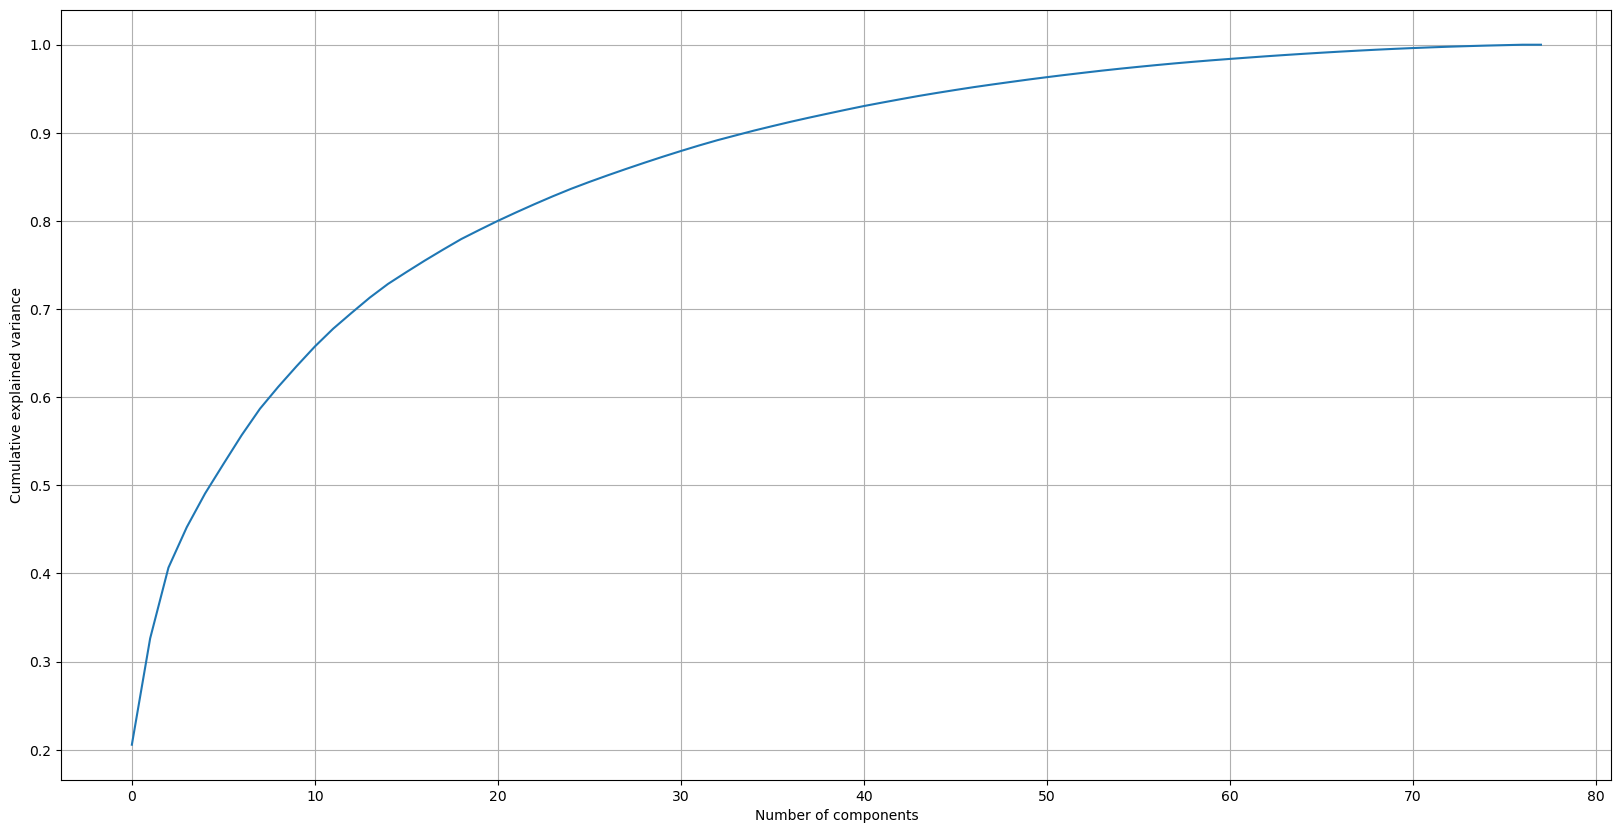

In [86]:
plot_pca_components(formatted_data)

%Variance  %CumulativeVariance
PC1  20.568896            20.568896
PC2  12.067081            32.635976
PC3   8.029132            40.665108

Principal Component Values


0             1             2         3         4             5    \
PC1 -0.025739  3.330669e-16  0.000000e+00  0.012392 -0.003027 -6.158268e-17   
PC2 -0.007800 -1.665335e-16  2.220446e-16  0.010330  0.007893  0.000000e+00   
PC3 -0.031649  4.163336e-16 -5.551115e-17  0.004428  0.011652 -4.996004e-16   

          6         7         8         9    ...       773       774  \
PC1 -0.044063  0.105633 -0.011058 -0.026801  ... -0.049305 -0.033699   
PC2  0.131918  0.033195  0.006757 -0.043607  ...  0.103290  0.106193   
PC3  0.017890  0.019372 -0.008561  0.111700  ... -0.000944  0.011341   

          775       776       777       778       779       780  781       782  
PC1 -0.044433 -0.039695 -0.044173 -0.050739 -0.045823 -0.043125  0.0 -0.018508  
PC2  0.093239  0.051439  0.063087  0.055397  0.053266  0.044919  0.0  0.066473  
PC3  0.004645  0.003529  0.012998  0.012468  0.009612  0.017925  0.0  0.002424  

[3 rows x 783 columns]

Displaying Top N features based on sensitivity for each PC


Top 1 Feature  \
PC1  Close__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"   
PC2                                    Close__absolute_sum_of_changes   
PC3    Close__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)   

                                                         Top 2 Feature  \
PC1                                 Close__linear_trend__attr_"rvalue"   
PC2  Close__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0   
PC3     Close__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)   

                                                      Top 3 Feature  
PC1                               Close__linear_trend__attr_"slope"  
PC2                                          Close__mean_abs_change  
PC3  Close__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)

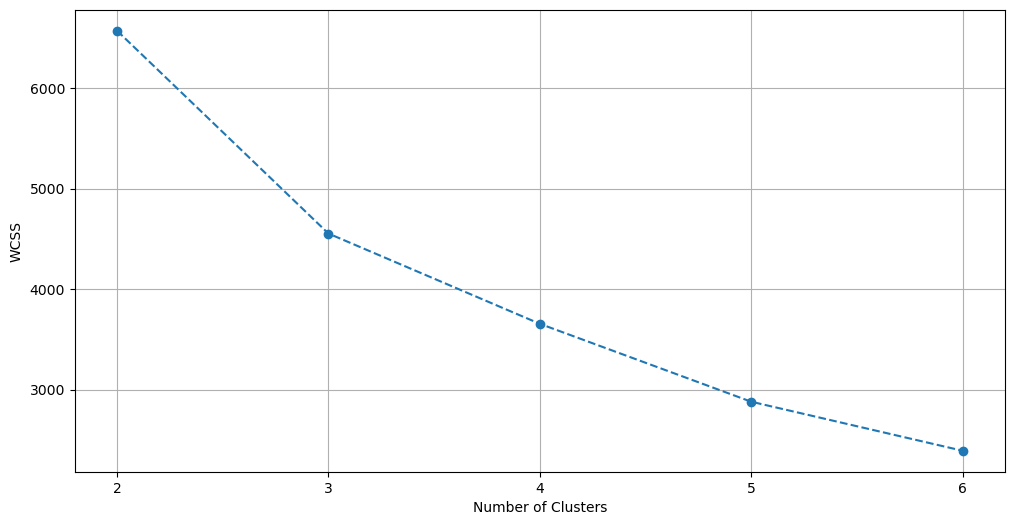

In [87]:
optimal_pca = PCA(n_components=3, svd_solver='full')
pca_data_train = optimal_pca.fit_transform(formatted_data)

# Display Variance Ratio and PCA Sensitivity for 3 PCs
df_variance_ratio = pd.DataFrame(np.array([optimal_pca.explained_variance_ratio_ * 100, optimal_pca.explained_variance_ratio_.cumsum() * 100]).transpose(), columns=['%Variance', '%CumulativeVariance'], index=['PC1', 'PC2', 'PC3'])
display(df_variance_ratio)

plot_pca_3components(optimal_pca.components_, extracted_data.columns)


min_clusters = 2
max_clusters = 6   
    
models, wcss = calculate_plot_wcss(pca_data_train, min_clusters, max_clusters)

In [88]:
km = models[determine_optimal_k_wcss(wcss, max_clusters) - min_clusters]
km

KMeans(max_iter=10, n_clusters=3, n_init=2, random_state=0)

In [89]:
y_pred_train = km.labels_

y_pred_train

array([1, 1, 2, 1, 2, 1, 2, 2, 0, 2, 1, 0, 1, 2, 1, 1, 0, 1, 0, 0, 2, 1,
       2, 1, 2, 2, 1, 1, 0, 0, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0, 0, 2, 1,
       0, 0, 2, 1, 0, 2, 1, 2, 0, 2, 1, 2, 1, 2, 0, 0, 1, 1, 1, 0, 2, 1,
       0, 1, 0, 0, 0, 1, 1, 2, 0, 2, 2, 0])

In [90]:
formatted_data, extracted_data = tsfresh_extract_features(test_df_3)

pca_data_test = optimal_pca.transform(formatted_data)

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.98it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   
5                                             0.0                       0.0   

   Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                       0.0                   0.0       7.904788e-14   
1                       0.0                   0.0       1.394440e-13   
2                       0.0                   0.0      -7.256418e-13   
3                       0.0                   0.0      -2.398082e-14   
4                       0.0                   1.0       4.440892e-16   
5                       0.0                   0.0       7.416290e-13   

   Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0               24.0                0.279414           -0.096743   
1               24.0                0.137773            0.121247   
2               24.0                0.504203            0.139814   
3               24.0                0.250941            0.127150   
4               24.0                0.413249            0.110330   
5               24.0                0.397261            0.123295   

   Close__mean_second_derivative_central  Close__median  ...  \
0                              -0.005585       0.134211  ...   
1                              -0.003016      -0.382016  ...   
2                               0.008562       0.091803  ...   
3                              -0.009858       0.460718  ...   
4                              -0.016155       0.081939  ...   
5                              -0.001317      -0.254585  ...   

   Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                        0.535961                         0.535961   
1                        0.271189                         0.535961   
2                        0.937156                         1.410514   
3                        0.793730                         0.793730   
4                        0.535961                         0.535961   
5                        0.830518                         1.303876   

   Close__fourier_entropy__bins_100  \
0                          1.178655   
1                          1.178655   
2                          2.351673   
3                          1.839297   
4                          1.732659   
5                          2.138397   

   Close__permutation_entropy__dimension_3__tau_1  \
0                                        1.657180   
1                                        0.838728   
2                                        1.567236   
3                                        1.606466   
4                                        1.538260   
5                                        1.540306   

   Close__permutation_entropy__dimension_4__tau_1  \
0                                        2.293452   
1                                        1.219137   
2                                        2.425480   
3                                        2.306336   
4                                        2.133211   
5                                        2.136507   

   Close__permutation_entropy__dimension_5__tau_1  \
0                                        2.718473   
1                                        1.607575   
2                                        2.787788   
3                                        2.649159   
4                                        2.622996   
5                                        2.510529   

   Close__permutation_entropy__dimension_6__tau_1  \
0                                        2.871476   
1                              

In [91]:
y_pred_test = km.predict(pca_data_test)

y_pred_test

array([1, 2, 0, 2, 0, 0])

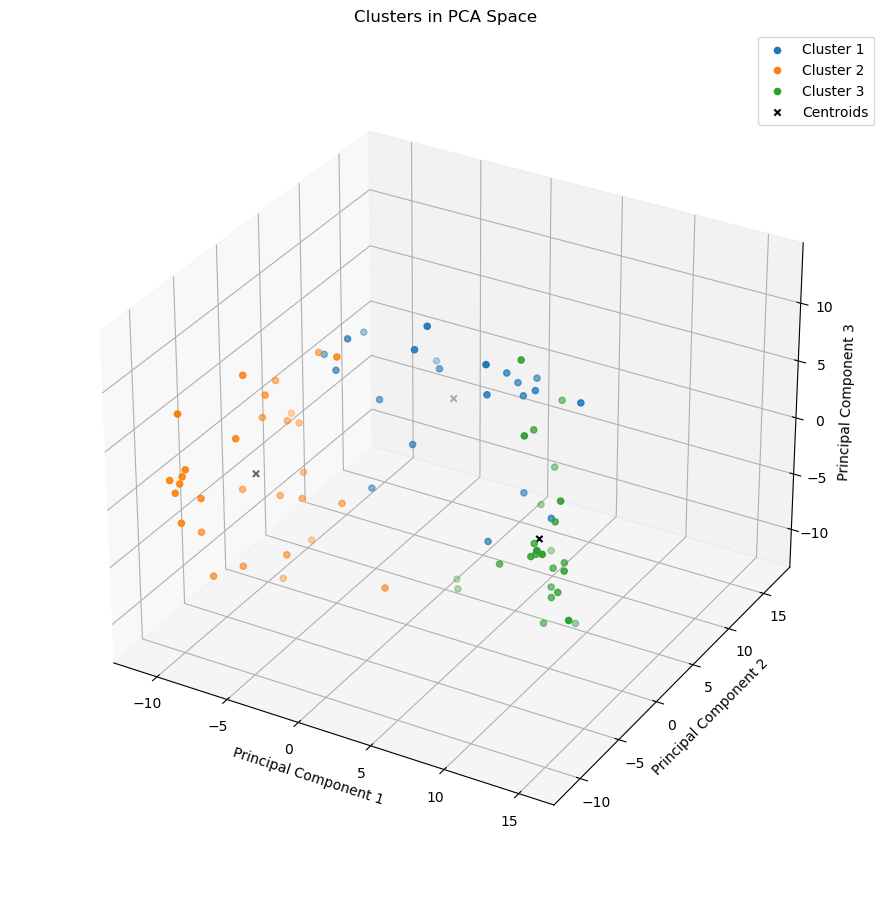

In [92]:
plot_pca_clusters_3d(km, pca_data_train)

### Applying the Analysis to all train-test periods for different n_components = 3 and >0.8

In [93]:
def df_transform_to_series(train_df, test_df):
    train_data = []
    Scaler = TimeSeriesScalerMeanVariance()

    for i in range(train_df.Week.nunique()):
        train_data.append(train_df.loc[train_df.Week == i].Close.to_numpy())
    
#     X_train = Scaler.fit_transform(train_data)
    
    test_data = []
    for i in range(test_df.Week.nunique()):
        test_data.append(test_df.loc[test_df.Week == i].Close.to_numpy())
    
#     X_test = Scaler.transform(test_data)
    
    return np.array(train_data), np.array(test_data)

In [94]:
def plot_pca_metrics(train_df, test_df, y_pred_train, y_pred_test, km, optimal_k, train_pca, test_pca):
    # Prep dataset
    X_train, X_test = df_transform_to_series(train_df, test_df)
    sz = X_train.shape[1]
    
    #Metrics
    print("Training Results")
    train_validation_index = ['wcss', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'silhouette_pca', 'calinski_harabasz_pca', 'davies_bouldin_pca']
    train_results = {vi: [] for vi in train_validation_index}

    for index in train_validation_index:
        if index == 'wcss':
            train_results[index].append(km.inertia_)
        else:
            train_results[index].append(compute_sklearn_metrics(X_train, y_pred_train, scoring=index, pca_features=train_pca))

    train_results_df = pd.DataFrame(train_results, index=[f"k={optimal_k}"])
    display(train_results_df)
    
    
    print("Testing Results")
    test_validation_index = ['wcss', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'silhouette_pca', 'calinski_harabasz_pca', 'davies_bouldin_pca']
    test_results = {vi: [] for vi in test_validation_index}

    for index in test_validation_index:
        if index == 'wcss':
            test_results[index].append(km.inertia_)
        else:
            test_results[index].append(compute_sklearn_metrics(X_test, y_pred_test, scoring=index, pca_features=test_pca))

    test_results_df = pd.DataFrame(test_results, index=[f"k={optimal_k}"])
    display(test_results_df)

    #Plotting
    subplot_index = 1
    plt.figure(figsize=(12, 9))

    for yi in range(optimal_k):
        plt.subplot(2, optimal_k, subplot_index + yi)
        for xx in X_train[y_pred_train == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
    #     plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == optimal_k//2:
            plt.title("DBA $k$-means (Training)")
    subplot_index += optimal_k

    for yi in range(optimal_k):
        plt.subplot(2, optimal_k, subplot_index + yi)
        for xx in X_test[y_pred_test == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
    #     plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == optimal_k//2:
            plt.title("DBA $k$-means (Testing)")
    subplot_index += optimal_k

    plt.tight_layout()
    plt.show()

In [95]:
def compute_sklearn_metrics(X, labels, scoring, metric=None, labels_true=None, km=None, X_train=None, pca_features=None):
    if X.size == 0 or labels.size == 0 or not scoring:
        print('Missing Parameters')
        return
    
    # Transform X for sklearn 
    X_ = to_time_series_dataset(X)
    X_ = X_.reshape((X.shape[0],-1))
    
    if scoring == 'silhouette':
        if metric == 'dtw':
            return silhouette_score(cdist_dtw(X_), labels, metric='precomputed')
        elif metric == 'softdtw':
            # Add gamma parameter if necessary
            return silhouette_score(cdist_soft_dtw_normalized(X_, gamma=0.01), labels, metric='precomputed')
        else:
            return silhouette_score(X_, labels)
    elif scoring == 'silhouette_pca':
        return silhouette_score(pca_features, labels)
    else:
        if scoring == 'calinski_harabasz':
            return calinski_harabasz_score(X_, labels)
        elif scoring == 'calinski_harabasz_pca':
            return calinski_harabasz_score(pca_features, labels)
        elif scoring == 'calinski_harabasz_dtw':
            return calinski_harabasz_score_dtw(X_, labels, km)
        elif scoring == 'davies_bouldin':
            return davies_bouldin_score(X_, labels)
        elif scoring == 'davies_bouldin_pca':
            return davies_bouldin_score(pca_features, labels)
        elif scoring == 'davies_bouldin_dtw':
            return davies_bouldin_score_dtw(X_, labels, km)
        elif scoring == 'davies_bouldin_medoids':
            return davies_bouldin_score_medoids(X_, labels, km, X_train)
        elif scoring == 'davies_bouldin_medoids_dtw':
            return davies_bouldin_score_medoids(X_, labels, km, X_train, dtw=True)   
        elif scoring == 'v_measure_score':
            return v_measure_score(labels_true, labels)

In [96]:
def generate_train_test_split_results(df, n_components, predefined_k=None):
    pred_results = []
    df = df.reset_index()
    
    tscv = TimeBasedCV(train_period=78, test_period=6, freq='weeks')
    min_clusters = 2
    max_clusters = 6
    
    for train_index, test_index in tscv.split(df, date_column='Datetime'):
        X_train_full = df.loc[train_index]
        X_train_full.set_index("Datetime", inplace = True)
        X_test_full = df.loc[test_index]
        X_test_full.set_index("Datetime", inplace = True)
        X_train, X_test = process_data(X_train_full, X_test_full)

        train_pca_data, _ = tsfresh_extract_features(X_train)
        test_pca_data, _ = tsfresh_extract_features(X_test)
        
        optimal_pca = PCA(n_components=n_components, svd_solver='full')
        train_pca_data = optimal_pca.fit_transform(train_pca_data)
        models, wcss = calculate_plot_wcss(train_pca_data, min_clusters, max_clusters)
        
        if not predefined_k:
            print("Determining optimal_k...")
            optimal_k = determine_optimal_k_wcss(wcss, max_clusters)
        else:
            optimal_k = predefined_k
        
        print(f"Optimal k is found to be {optimal_k}")
        km = models[optimal_k - min_clusters]
        y_pred_train = km.labels_
        
        test_pca_data = optimal_pca.transform(test_pca_data)
        y_pred_test = km.predict(test_pca_data)
        pred_results.append((y_pred_train, y_pred_test))
        
        plot_pca_metrics(X_train, X_test, y_pred_train, y_pred_test, km, optimal_k, train_pca_data, test_pca_data)
        
        
    return pred_results

#### n_components = 3

Train period: 2022-01-31 - 2023-07-31 , Test period 2023-07-31 - 2023-09-11 # train records 2617 , # test records 203
Train period: 2022-03-14 - 2023-09-11 , Test period 2023-09-11 - 2023-10-23 # train records 2617 , # test records 210
Train period: 2022-04-25 - 2023-10-23 , Test period 2023-10-23 - 2023-12-04 # train records 2624 , # test records 199
Train period: 2022-06-06 - 2023-12-04 , Test period 2023-12-04 - 2024-01-15 # train records 2620 , # test records 196


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  9.46it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                              0.0                       0.0   
1                                              0.0                       0.0   
2                                              0.0                       0.0   
3                                              0.0                       0.0   
4                                              0.0                       0.0   
..                                             ...                       ...   
73                                             0.0                       0.0   
74                                             1.0                       0.0   
75                                             0.0                       0.0   
76                                             0.0                       0.0   
77                                             0.0                       0.0   

    Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                        0.0                   0.0      -2.140510e-13   
1                        0.0                   0.0       6.084022e-14   
2                        0.0                   0.0      -4.407585e-14   
3                        0.0                   0.0      -5.517808e-14   
4                        0.0                   0.0       3.743672e-13   
..                       ...                   ...                ...   
73                       0.0                   0.0      -4.884981e-14   
74                       0.0                   0.0      -3.363976e-13   
75                       0.0                   0.0       6.461498e-14   
76                       0.0                   0.0       1.083578e-13   
77                       0.0                   0.0      -8.180123e-13   

    Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0                24.0                0.419473            0.053397   
1                24.0                0.321532           -0.091977   
2                24.0                0.386569           -0.055142   
3                24.0                0.326490            0.015070   
4                24.0                0.642222           -0.011652   
..                ...                     ...                 ...   
73               24.0                0.240896            0.108922   
74               24.0                0.382289           -0.104666   
75               24.0                0.185084            0.102253   
76               24.0                0.405061            0.064018   
77               24.0                0.660535            0.088414   

    Close__mean_second_derivative_central  Close__median  ...  \
0                               -0.020716      -0.082317  ...   
1                                0.004883      -0.139878  ...   
2                               -0.013821      -0.008060  ...   
3                                0.017946       0.039334  ...   
4                               -0.012727      -0.046950  ...   
..                                    ...            ...  ...   
73                               0.005964      -0.208100  ...   
74                              -0.019780       0.052481  ...   
75                               0.003431       0.272446  ...   
76                              -0.015402       0.099829  ...   
77                              -0.001995      -0.217813  ...   

    Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                         0.793730                         0.793730   
1                         0.793730                         0.793730   
2                         0.535961                         0.793730   
3                         0.793730                         0.793730   
4                         0.687092                         1.178655   
..                             ...                              ...   
73                        0.271189                         

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.01it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                             1.0                       0.0   
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             1.0                       0.0   
4                                             1.0                       0.0   
5                                             0.0                       0.0   

   Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                       0.0                   0.0      -3.796963e-13   
1                       0.0                   0.0      -5.417888e-14   
2                       0.0                   0.0      -2.970957e-13   
3                       0.0                   0.0      -2.886580e-13   
4                       0.0                   0.0       8.881784e-16   
5                       0.0                   0.0      -1.013412e-12   

   Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0               24.0                0.306347           -0.133997   
1               24.0                0.568946           -0.111470   
2               24.0                0.232172           -0.099540   
3               24.0                0.438643            0.074242   
4               24.0                0.283416            0.095907   
5               24.0                0.343735           -0.090558   

   Close__mean_second_derivative_central  Close__median  ...  \
0                              -0.003480      -0.349153  ...   
1                               0.002061      -0.315104  ...   
2                              -0.003485       0.144855  ...   
3                              -0.006435      -0.240491  ...   
4                               0.014496       0.467283  ...   
5                               0.003112      -0.352405  ...   

   Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                        0.535961                         0.535961   
1                        1.412745                         1.925121   
2                        0.271189                         0.271189   
3                        0.830518                         0.937156   
4                        0.535961                         0.535961   
5                        0.535961                         0.937156   

   Close__fourier_entropy__bins_100  \
0                          1.839297   
1                          2.458311   
2                          1.178655   
3                          1.631345   
4                          1.326920   
5                          2.204785   

   Close__permutation_entropy__dimension_3__tau_1  \
0                                        1.657180   
1                                        1.751084   
2                                        1.657994   
3                                        1.570383   
4                                        1.550559   
5                                        1.526775   

   Close__permutation_entropy__dimension_4__tau_1  \
0                                        2.334549   
1                                        2.557508   
2                                        2.441661   
3                                        2.136507   
4                                        2.177604   
5                                        2.131830   

   Close__permutation_entropy__dimension_5__tau_1  \
0                                        2.857103   
1                                        2.995732   
2                                        2.622996   
3                                        2.553682   
4                                        2.524058   
5                                        2.524058   

   Close__permutation_entropy__dimension_6__tau_1  \
0                                        2.944439   
1                              

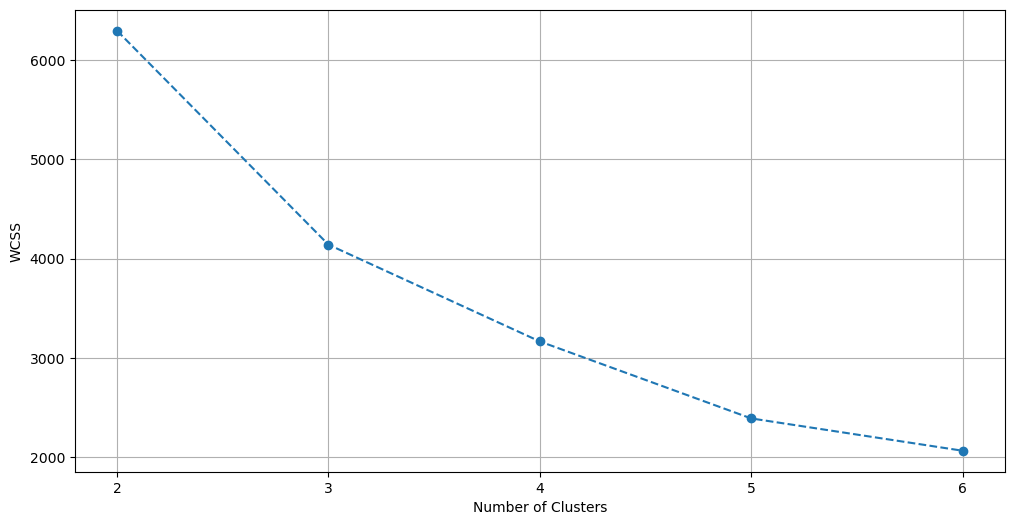

Determining optimal_k...
Optimal k is found to be 3
Training Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=3  4140.62499    0.248148          23.627535        2.153723   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=3        0.333774              64.545065            0.982209

Testing Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=3  4140.62499    0.118099           3.148967        0.930106   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=3        0.091689               4.423078             0.64308

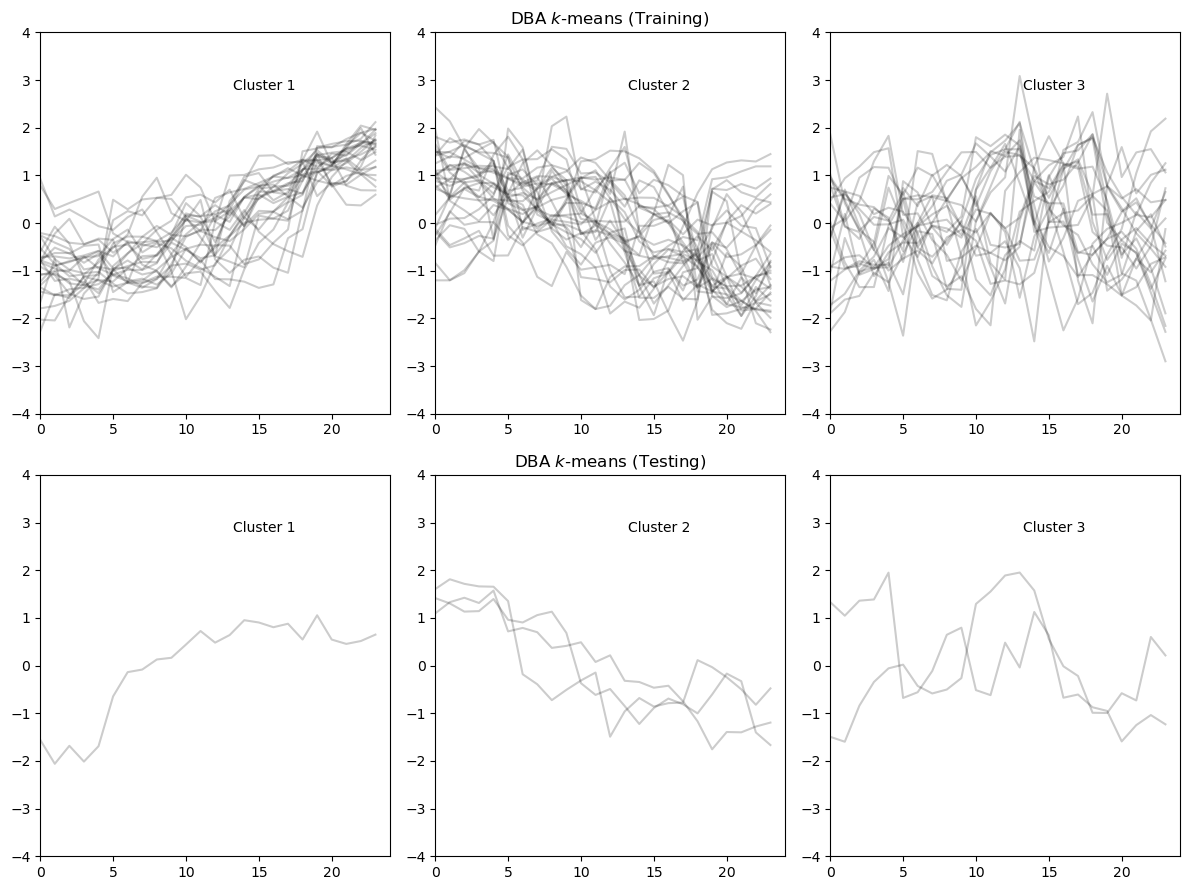

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  9.08it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                              0.0                       0.0   
1                                              0.0                       0.0   
2                                              0.0                       0.0   
3                                              0.0                       0.0   
4                                              0.0                       0.0   
..                                             ...                       ...   
73                                             0.0                       0.0   
74                                             0.0                       0.0   
75                                             1.0                       0.0   
76                                             1.0                       0.0   
77                                             0.0                       0.0   

    Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                        0.0                   0.0       2.065015e-13   
1                        0.0                   0.0      -5.617729e-13   
2                        0.0                   0.0       1.045830e-13   
3                        0.0                   0.0       4.498624e-13   
4                        0.0                   0.0       3.719247e-13   
..                       ...                   ...                ...   
73                       0.0                   0.0      -5.417888e-14   
74                       0.0                   0.0      -2.970957e-13   
75                       0.0                   0.0      -2.886580e-13   
76                       0.0                   0.0       8.881784e-16   
77                       0.0                   0.0      -1.013412e-12   

    Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0                24.0                0.239640            0.108974   
1                24.0                0.487631            0.152095   
2                24.0                0.335758            0.000601   
3                24.0                0.306370           -0.080594   
4                24.0                0.636021           -0.124546   
..                ...                     ...                 ...   
73               24.0                0.568946           -0.111470   
74               24.0                0.232172           -0.099540   
75               24.0                0.438643            0.074242   
76               24.0                0.283416            0.095907   
77               24.0                0.343735           -0.090558   

    Close__mean_second_derivative_central  Close__median  ...  \
0                                0.007723       0.163207  ...   
1                               -0.005901       0.208599  ...   
2                                0.016697       0.241685  ...   
3                               -0.008853      -0.224293  ...   
4                               -0.011186       0.212779  ...   
..                                    ...            ...  ...   
73                               0.002061      -0.315104  ...   
74                              -0.003485       0.144855  ...   
75                              -0.006435      -0.240491  ...   
76                               0.014496       0.467283  ...   
77                               0.003112      -0.352405  ...   

    Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                         0.271189                         0.271189   
1                         0.535961                         0.793730   
2                         0.535961                         0.793730   
3                         0.687092                         0.793730   
4                         0.687092                         1.178655   
..                             ...                              ...   
73                        1.412745                         

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.02it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             1.0                       0.0   
2                                             0.0                       0.0   
3                                             1.0                       0.0   
4                                             0.0                       0.0   
5                                             0.0                       0.0   

   Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                       0.0                   0.0       7.656098e-13   
1                       0.0                   0.0       4.853895e-13   
2                       0.0                   0.0      -5.715428e-13   
3                       0.0                   0.0      -3.033129e-13   
4                       0.0                   0.0      -3.130829e-13   
5                       0.0                   0.0       4.440892e-16   

   Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0               24.0                0.540308           -0.084657   
1               24.0                0.227151           -0.113128   
2               24.0                0.474234           -0.044379   
3               24.0                0.511423            0.042324   
4               24.0                0.468057            0.059283   
5               24.0                0.230265           -0.124036   

   Close__mean_second_derivative_central  Close__median  ...  \
0                               0.000635      -0.012983  ...   
1                              -0.011214       0.457230  ...   
2                              -0.014185      -0.224917  ...   
3                              -0.012517      -0.187153  ...   
4                              -0.003001       0.293475  ...   
5                              -0.007623       0.234123  ...   

   Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                        0.937156                         1.303876   
1                        0.535961                         0.793730   
2                        0.793730                         0.793730   
3                        0.793730                         1.043794   
4                        0.687092                         1.043794   
5                        0.271189                         0.271189   

   Close__fourier_entropy__bins_100  \
0                          2.311423   
1                          1.484458   
2                          2.098147   
3                          2.204785   
4                          2.311423   
5                          1.377820   

   Close__permutation_entropy__dimension_3__tau_1  \
0                                        1.656676   
1                                        1.388449   
2                                        1.756276   
3                                        1.751084   
4                                        1.546599   
5                                        1.516522   

   Close__permutation_entropy__dimension_4__tau_1  \
0                                        2.557508   
1                                        2.108294   
2                                        2.714452   
3                                        2.623522   
4                                        2.284716   
5                                        2.372350   

   Close__permutation_entropy__dimension_5__tau_1  \
0                                        2.787788   
1                                        2.622996   
2                                        2.926418   
3                                        2.857103   
4                                        2.718473   
5                                        2.830940   

   Close__permutation_entropy__dimension_6__tau_1  \
0                                        2.944439   
1                              

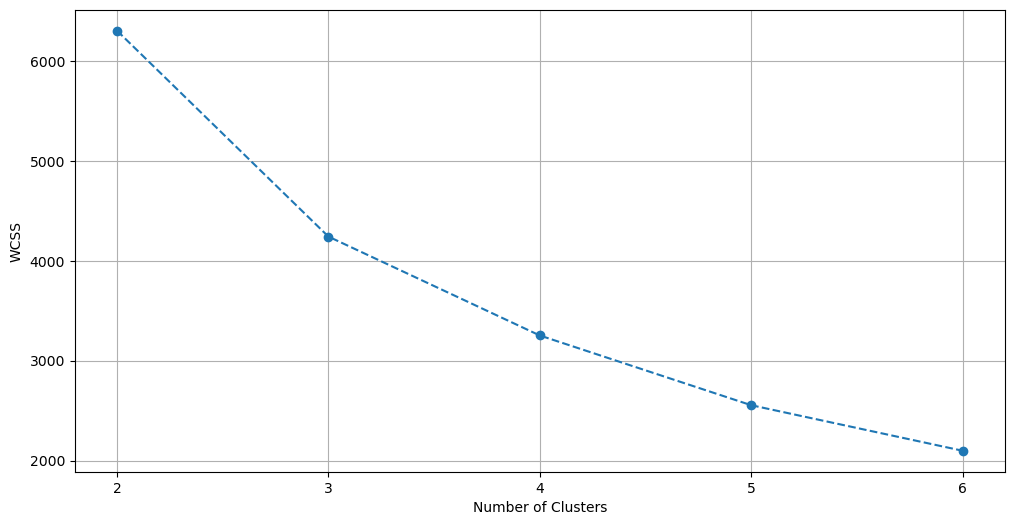

Determining optimal_k...
Optimal k is found to be 3
Training Results


wcss  silhouette  calinski_harabasz  davies_bouldin  silhouette_pca  \
k=3  4242.1843    0.282162          28.079804        2.067411        0.335057   

     calinski_harabasz_pca  davies_bouldin_pca  
k=3               64.19679             0.98364

Testing Results


wcss  silhouette  calinski_harabasz  davies_bouldin  silhouette_pca  \
k=3  4242.1843    0.230149           2.183119        0.827457        0.334465   

     calinski_harabasz_pca  davies_bouldin_pca  
k=3               6.196497            0.526569

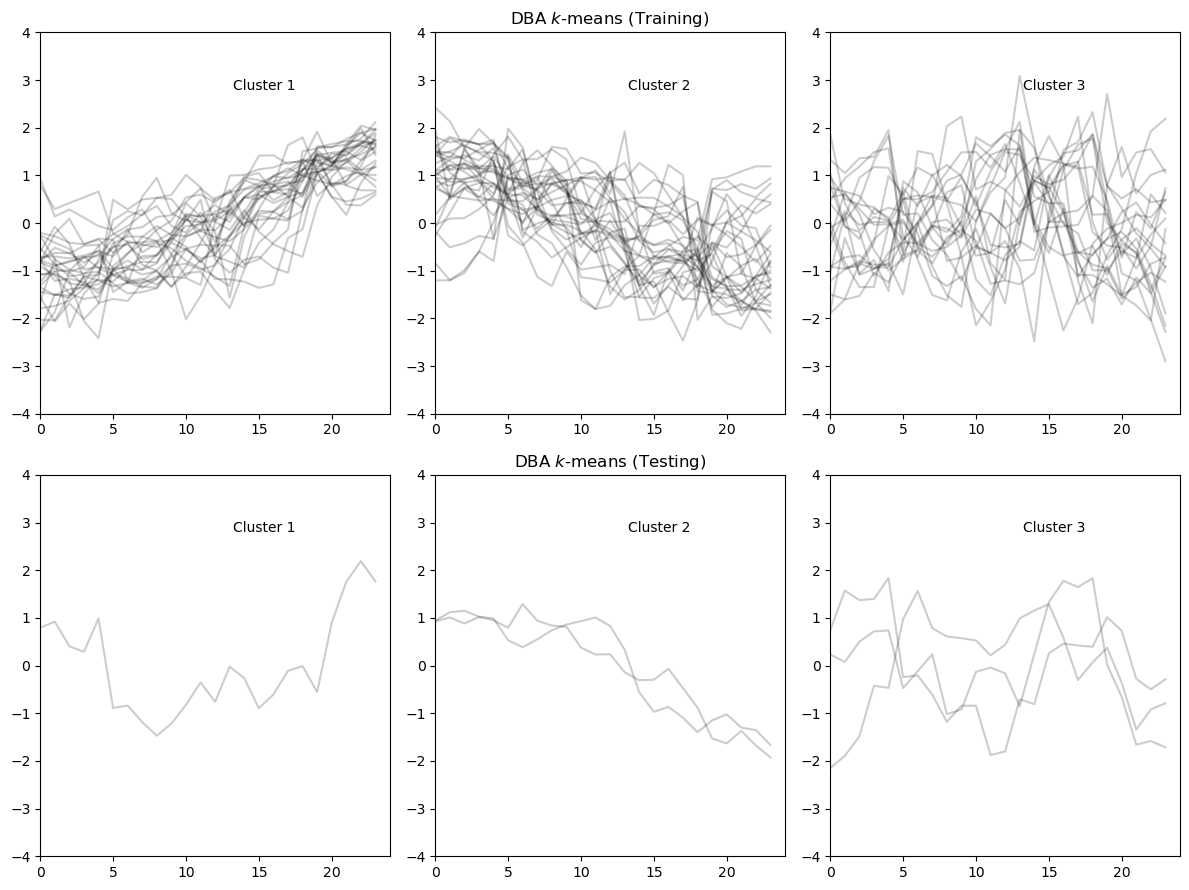

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  8.82it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                              1.0                       0.0   
1                                              1.0                       0.0   
2                                              0.0                       0.0   
3                                              1.0                       0.0   
4                                              0.0                       0.0   
..                                             ...                       ...   
73                                             1.0                       0.0   
74                                             0.0                       0.0   
75                                             1.0                       0.0   
76                                             0.0                       0.0   
77                                             0.0                       0.0   

    Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                        0.0                   0.0       5.018208e-13   
1                        0.0                   0.0      -8.615331e-14   
2                        0.0                   0.0       6.150636e-14   
3                        0.0                   0.0      -1.709743e-13   
4                        0.0                   0.0       1.256772e-13   
..                       ...                   ...                ...   
73                       0.0                   0.0       4.853895e-13   
74                       0.0                   0.0      -5.715428e-13   
75                       0.0                   0.0      -3.033129e-13   
76                       0.0                   0.0      -3.130829e-13   
77                       0.0                   0.0       4.440892e-16   

    Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0                24.0                0.621284           -0.117071   
1                24.0                0.592768           -0.033562   
2                24.0                0.484463           -0.010443   
3                24.0                0.302137           -0.068818   
4                24.0                0.247025            0.117478   
..                ...                     ...                 ...   
73               24.0                0.227151           -0.113128   
74               24.0                0.474234           -0.044379   
75               24.0                0.511423            0.042324   
76               24.0                0.468057            0.059283   
77               24.0                0.230265           -0.124036   

    Close__mean_second_derivative_central  Close__median  ...  \
0                               -0.010043       0.013040  ...   
1                                0.033783       0.024077  ...   
2                                0.011137       0.481173  ...   
3                                0.022547      -0.138479  ...   
4                               -0.001461      -0.464381  ...   
..                                    ...            ...  ...   
73                              -0.011214       0.457230  ...   
74                              -0.014185      -0.224917  ...   
75                              -0.012517      -0.187153  ...   
76                              -0.003001       0.293475  ...   
77                              -0.007623       0.234123  ...   

    Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                         1.072017                         1.285293   
1                         1.072017                         1.418069   
2                         0.687092                         1.178655   
3                         0.535961                         0.535961   
4                         0.271189                         0.535961   
..                             ...                              ...   
73                        0.535961                         

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.92it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   
5                                             0.0                       0.0   

   Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                       0.0                   0.0       7.904788e-14   
1                       0.0                   0.0       1.394440e-13   
2                       0.0                   0.0      -7.256418e-13   
3                       0.0                   0.0      -2.398082e-14   
4                       0.0                   1.0       4.440892e-16   
5                       0.0                   0.0       7.416290e-13   

   Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0               24.0                0.279414           -0.096743   
1               24.0                0.137773            0.121247   
2               24.0                0.504203            0.139814   
3               24.0                0.250941            0.127150   
4               24.0                0.413249            0.110330   
5               24.0                0.397261            0.123295   

   Close__mean_second_derivative_central  Close__median  ...  \
0                              -0.005585       0.134211  ...   
1                              -0.003016      -0.382016  ...   
2                               0.008562       0.091803  ...   
3                              -0.009858       0.460718  ...   
4                              -0.016155       0.081939  ...   
5                              -0.001317      -0.254585  ...   

   Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                        0.535961                         0.535961   
1                        0.271189                         0.535961   
2                        0.937156                         1.410514   
3                        0.793730                         0.793730   
4                        0.535961                         0.535961   
5                        0.830518                         1.303876   

   Close__fourier_entropy__bins_100  \
0                          1.178655   
1                          1.178655   
2                          2.351673   
3                          1.839297   
4                          1.732659   
5                          2.138397   

   Close__permutation_entropy__dimension_3__tau_1  \
0                                        1.657180   
1                                        0.838728   
2                                        1.567236   
3                                        1.606466   
4                                        1.538260   
5                                        1.540306   

   Close__permutation_entropy__dimension_4__tau_1  \
0                                        2.293452   
1                                        1.219137   
2                                        2.425480   
3                                        2.306336   
4                                        2.133211   
5                                        2.136507   

   Close__permutation_entropy__dimension_5__tau_1  \
0                                        2.718473   
1                                        1.607575   
2                                        2.787788   
3                                        2.649159   
4                                        2.622996   
5                                        2.510529   

   Close__permutation_entropy__dimension_6__tau_1  \
0                                        2.871476   
1                              

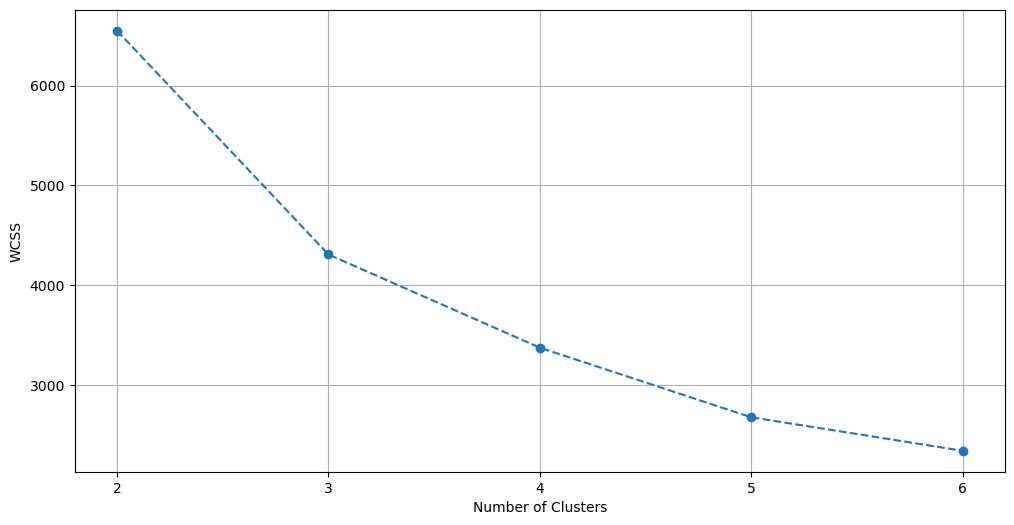

Determining optimal_k...
Optimal k is found to be 3
Training Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=3  4306.650264    0.285215          28.385379        1.834428   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=3        0.326026              62.853717            0.984921

Testing Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=3  4306.650264   -0.094461           2.110852        0.916179   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=3        0.213313               5.193379            0.350382

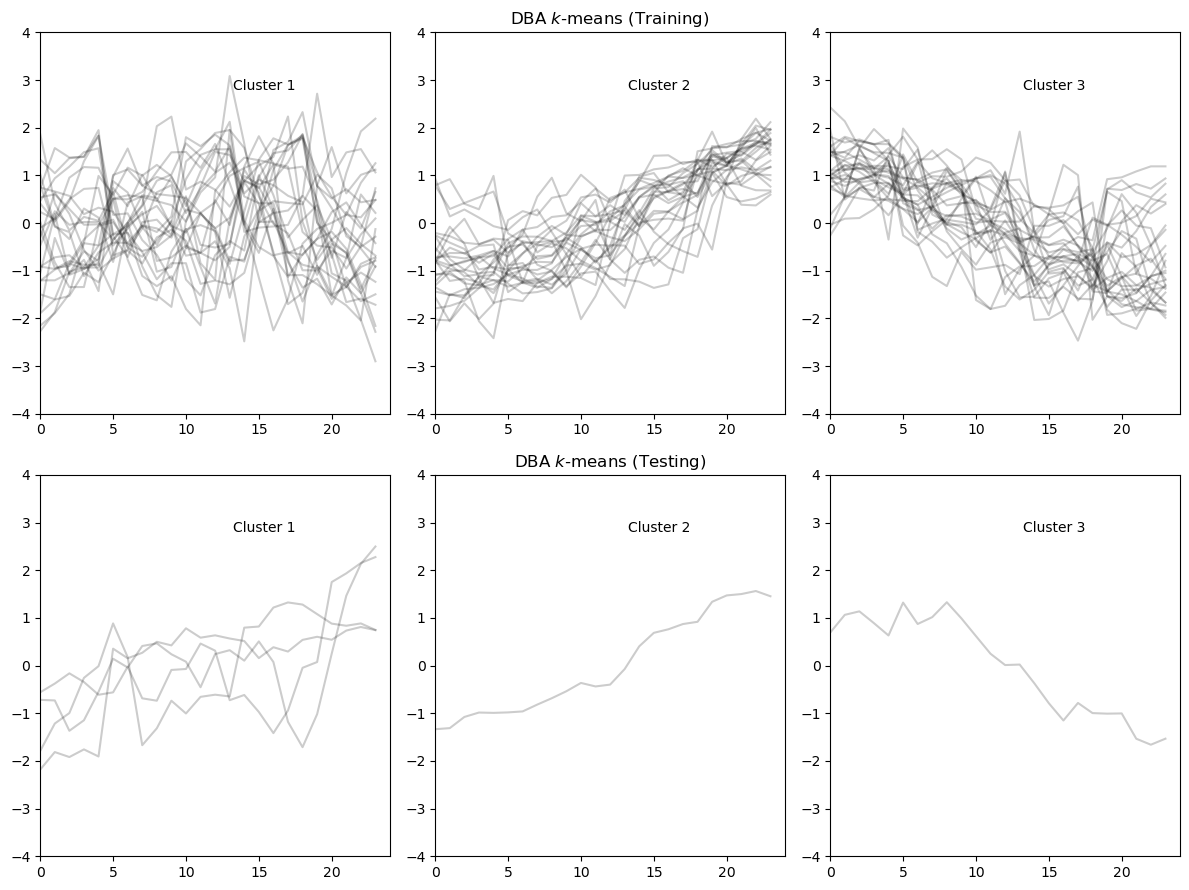

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  8.68it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                              1.0                       0.0   
1                                              1.0                       0.0   
2                                              0.0                       0.0   
3                                              1.0                       0.0   
4                                              0.0                       0.0   
..                                             ...                       ...   
73                                             0.0                       0.0   
74                                             0.0                       0.0   
75                                             0.0                       0.0   
76                                             0.0                       0.0   
77                                             0.0                       0.0   

    Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                        0.0                   0.0       1.896261e-13   
1                        0.0                   0.0       1.394440e-13   
2                        0.0                   0.0       3.246292e-13   
3                        0.0                   0.0      -1.743050e-13   
4                        0.0                   0.0      -3.641532e-14   
..                       ...                   ...                ...   
73                       0.0                   0.0       1.394440e-13   
74                       0.0                   0.0      -7.256418e-13   
75                       0.0                   0.0      -2.398082e-14   
76                       0.0                   1.0       4.440892e-16   
77                       0.0                   0.0       7.416290e-13   

    Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0                24.0                0.201673           -0.129051   
1                24.0                0.433708           -0.094681   
2                24.0                0.227536            0.122829   
3                24.0                0.323063           -0.068031   
4                24.0                0.222375            0.127096   
..                ...                     ...                 ...   
73               24.0                0.137773            0.121247   
74               24.0                0.504203            0.139814   
75               24.0                0.250941            0.127150   
76               24.0                0.413249            0.110330   
77               24.0                0.397261            0.123295   

    Close__mean_second_derivative_central  Close__median  ...  \
0                                0.002027       0.464347  ...   
1                               -0.014649       0.243460  ...   
2                                0.007731      -0.468421  ...   
3                               -0.000576      -0.196351  ...   
4                               -0.003530       0.309669  ...   
..                                    ...            ...  ...   
73                              -0.003016      -0.382016  ...   
74                               0.008562       0.091803  ...   
75                              -0.009858       0.460718  ...   
76                              -0.016155       0.081939  ...   
77                              -0.001317      -0.254585  ...   

    Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                         0.535961                         0.793730   
1                         0.687092                         0.937156   
2                         0.687092                         1.043794   
3                         0.535961                         0.535961   
4                         0.271189                         0.687092   
..                             ...                              ...   
73                        0.271189                         

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.83it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             0.0                       0.0   
2                                             1.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   
5                                             1.0                       0.0   

   Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                       0.0                   0.0       6.568079e-13   
1                       0.0                   0.0      -2.255973e-13   
2                       0.0                   0.0      -2.547962e-13   
3                       0.0                   0.0       2.429390e-12   
4                       0.0                   0.0      -2.158274e-13   
5                       0.0                   0.0       6.785683e-13   

   Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0               24.0                0.362205            0.148735   
1               24.0                0.162353            0.109294   
2               24.0                0.556319            0.040252   
3               24.0                0.494184            0.019648   
4               24.0                0.532661           -0.101884   
5               24.0                0.412636            0.152559   

   Close__mean_second_derivative_central  Close__median  ...  \
0                              -0.012228      -0.350958  ...   
1                               0.000665      -0.239022  ...   
2                               0.001525       0.161798  ...   
3                              -0.004418      -0.065238  ...   
4                               0.002404      -0.072318  ...   
5                              -0.005118       0.077436  ...   

   Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                        0.793730                         1.043794   
1                        0.535961                         0.535961   
2                        0.687092                         1.263626   
3                        0.793730                         1.043794   
4                        0.535961                         1.118969   
5                        1.303876                         1.732659   

   Close__fourier_entropy__bins_100  \
0                          2.204785   
1                          1.410514   
2                          2.351673   
3                          2.098147   
4                          2.098147   
5                          2.031759   

   Close__permutation_entropy__dimension_3__tau_1  \
0                                        1.492738   
1                                        1.222602   
2                                        1.562044   
3                                        1.684924   
4                                        1.684924   
5                                        1.555751   

   Close__permutation_entropy__dimension_4__tau_1  \
0                                        2.309633   
1                                        1.656454   
2                                        2.595309   
3                                        2.516410   
4                                        2.598605   
5                                        2.238941   

   Close__permutation_entropy__dimension_5__tau_1  \
0                                        2.692311   
1                                        2.094641   
2                                        2.857103   
3                                        2.857103   
4                                        2.857103   
5                                        2.553682   

   Close__permutation_entropy__dimension_6__tau_1  \
0                                        2.798513   
1                              

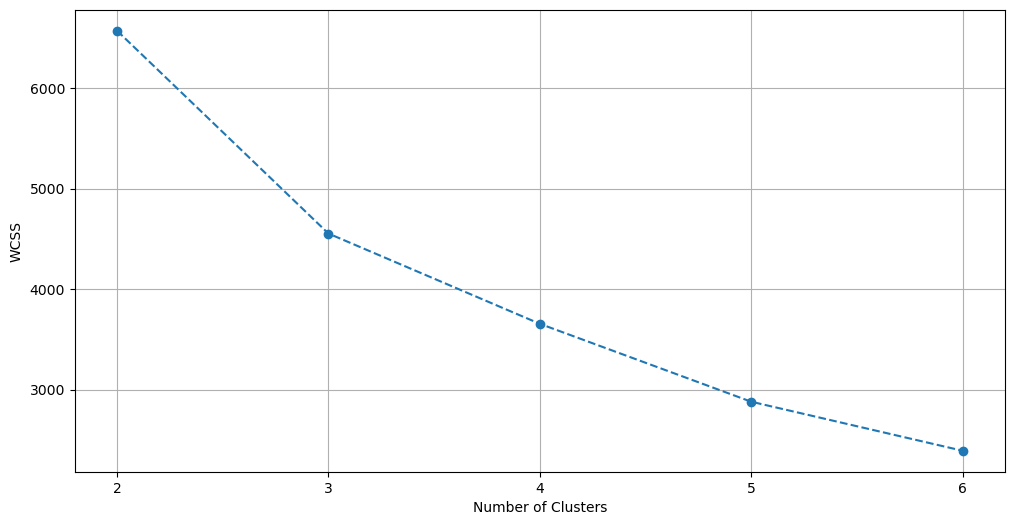

Determining optimal_k...
Optimal k is found to be 3
Training Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=3  4552.716862    0.267469          28.317326        2.024534   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=3        0.327551              57.860831            0.999277

Testing Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=3  4552.716862    0.421603           2.398016        1.068603   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=3        0.346919               5.153914             0.46644

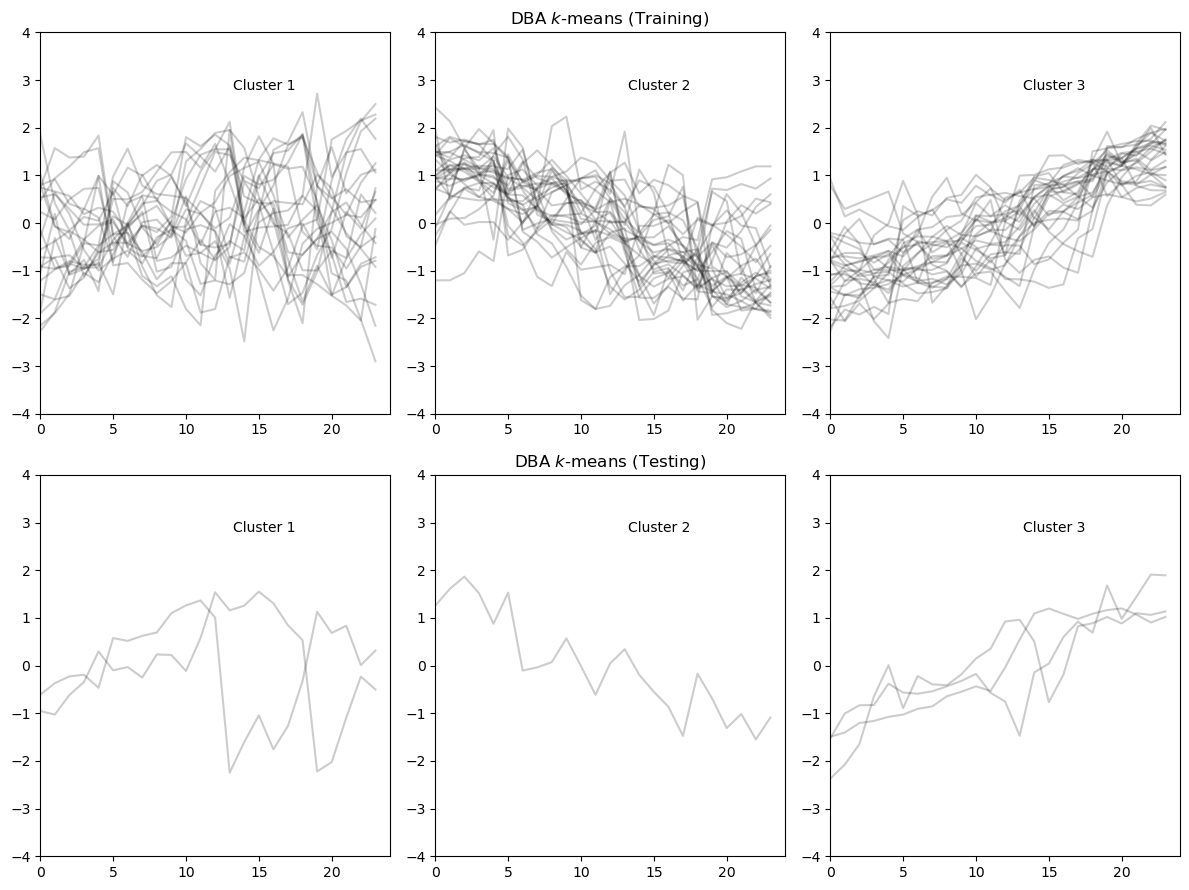

In [97]:
three_comp_pred_results = generate_train_test_split_results(df, n_components=3)

#### n_components = 0.8

Train period: 2022-01-31 - 2023-07-31 , Test period 2023-07-31 - 2023-09-11 # train records 2617 , # test records 203
Train period: 2022-03-14 - 2023-09-11 , Test period 2023-09-11 - 2023-10-23 # train records 2617 , # test records 210
Train period: 2022-04-25 - 2023-10-23 , Test period 2023-10-23 - 2023-12-04 # train records 2624 , # test records 199
Train period: 2022-06-06 - 2023-12-04 , Test period 2023-12-04 - 2024-01-15 # train records 2620 , # test records 196


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  9.29it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                              0.0                       0.0   
1                                              0.0                       0.0   
2                                              0.0                       0.0   
3                                              0.0                       0.0   
4                                              0.0                       0.0   
..                                             ...                       ...   
73                                             0.0                       0.0   
74                                             1.0                       0.0   
75                                             0.0                       0.0   
76                                             0.0                       0.0   
77                                             0.0                       0.0   

    Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                        0.0                   0.0      -2.140510e-13   
1                        0.0                   0.0       6.084022e-14   
2                        0.0                   0.0      -4.407585e-14   
3                        0.0                   0.0      -5.517808e-14   
4                        0.0                   0.0       3.743672e-13   
..                       ...                   ...                ...   
73                       0.0                   0.0      -4.884981e-14   
74                       0.0                   0.0      -3.363976e-13   
75                       0.0                   0.0       6.461498e-14   
76                       0.0                   0.0       1.083578e-13   
77                       0.0                   0.0      -8.180123e-13   

    Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0                24.0                0.419473            0.053397   
1                24.0                0.321532           -0.091977   
2                24.0                0.386569           -0.055142   
3                24.0                0.326490            0.015070   
4                24.0                0.642222           -0.011652   
..                ...                     ...                 ...   
73               24.0                0.240896            0.108922   
74               24.0                0.382289           -0.104666   
75               24.0                0.185084            0.102253   
76               24.0                0.405061            0.064018   
77               24.0                0.660535            0.088414   

    Close__mean_second_derivative_central  Close__median  ...  \
0                               -0.020716      -0.082317  ...   
1                                0.004883      -0.139878  ...   
2                               -0.013821      -0.008060  ...   
3                                0.017946       0.039334  ...   
4                               -0.012727      -0.046950  ...   
..                                    ...            ...  ...   
73                               0.005964      -0.208100  ...   
74                              -0.019780       0.052481  ...   
75                               0.003431       0.272446  ...   
76                              -0.015402       0.099829  ...   
77                              -0.001995      -0.217813  ...   

    Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                         0.793730                         0.793730   
1                         0.793730                         0.793730   
2                         0.535961                         0.793730   
3                         0.793730                         0.793730   
4                         0.687092                         1.178655   
..                             ...                              ...   
73                        0.271189                         

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.78it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                             1.0                       0.0   
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             1.0                       0.0   
4                                             1.0                       0.0   
5                                             0.0                       0.0   

   Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                       0.0                   0.0      -3.796963e-13   
1                       0.0                   0.0      -5.417888e-14   
2                       0.0                   0.0      -2.970957e-13   
3                       0.0                   0.0      -2.886580e-13   
4                       0.0                   0.0       8.881784e-16   
5                       0.0                   0.0      -1.013412e-12   

   Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0               24.0                0.306347           -0.133997   
1               24.0                0.568946           -0.111470   
2               24.0                0.232172           -0.099540   
3               24.0                0.438643            0.074242   
4               24.0                0.283416            0.095907   
5               24.0                0.343735           -0.090558   

   Close__mean_second_derivative_central  Close__median  ...  \
0                              -0.003480      -0.349153  ...   
1                               0.002061      -0.315104  ...   
2                              -0.003485       0.144855  ...   
3                              -0.006435      -0.240491  ...   
4                               0.014496       0.467283  ...   
5                               0.003112      -0.352405  ...   

   Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                        0.535961                         0.535961   
1                        1.412745                         1.925121   
2                        0.271189                         0.271189   
3                        0.830518                         0.937156   
4                        0.535961                         0.535961   
5                        0.535961                         0.937156   

   Close__fourier_entropy__bins_100  \
0                          1.839297   
1                          2.458311   
2                          1.178655   
3                          1.631345   
4                          1.326920   
5                          2.204785   

   Close__permutation_entropy__dimension_3__tau_1  \
0                                        1.657180   
1                                        1.751084   
2                                        1.657994   
3                                        1.570383   
4                                        1.550559   
5                                        1.526775   

   Close__permutation_entropy__dimension_4__tau_1  \
0                                        2.334549   
1                                        2.557508   
2                                        2.441661   
3                                        2.136507   
4                                        2.177604   
5                                        2.131830   

   Close__permutation_entropy__dimension_5__tau_1  \
0                                        2.857103   
1                                        2.995732   
2                                        2.622996   
3                                        2.553682   
4                                        2.524058   
5                                        2.524058   

   Close__permutation_entropy__dimension_6__tau_1  \
0                                        2.944439   
1                              

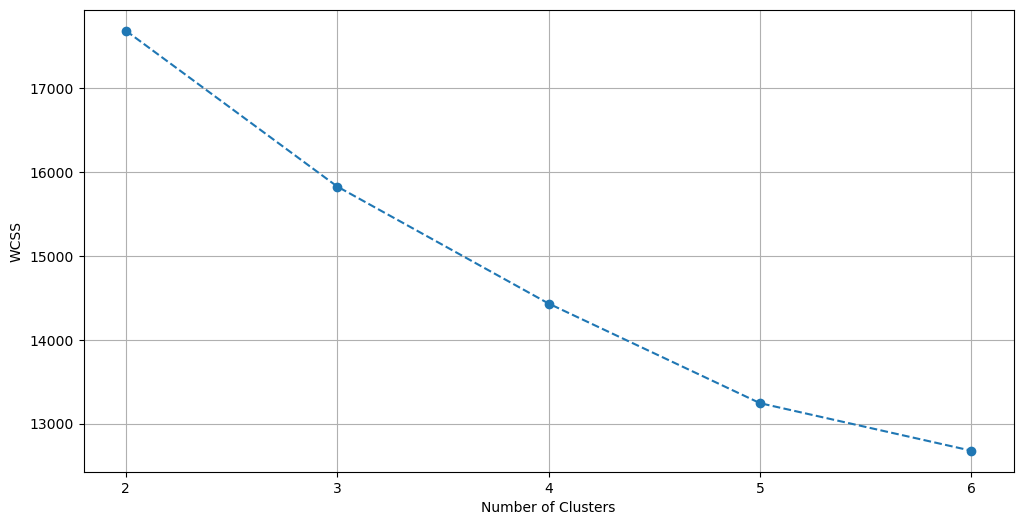

Determining optimal_k...
Optimal k is found to be 4
Training Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=4  14432.205788    0.250674          23.389531        1.803029   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=4        0.154499              14.171651            2.066027

Testing Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=4  14432.205788   -0.146795           1.790828        0.824678   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=4       -0.099341               1.811929            0.825462

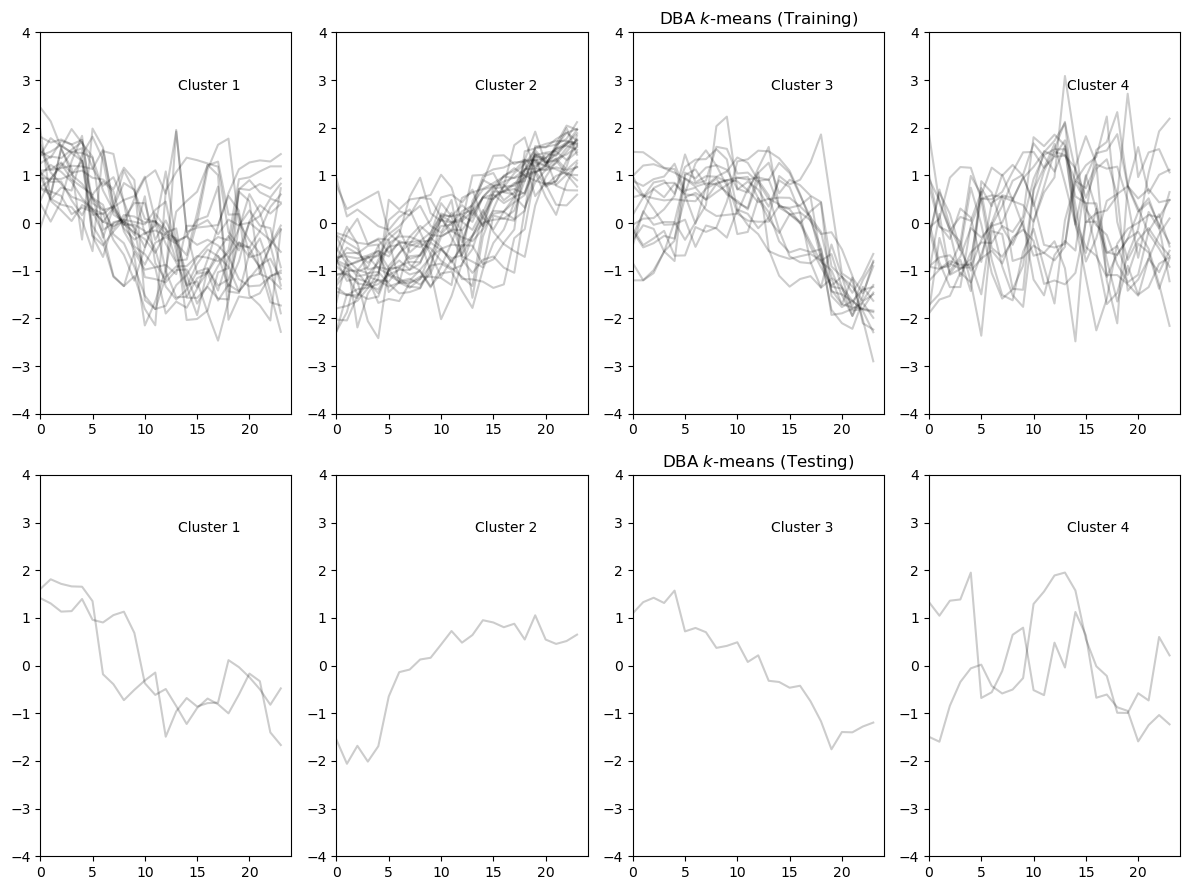

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  8.37it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                              0.0                       0.0   
1                                              0.0                       0.0   
2                                              0.0                       0.0   
3                                              0.0                       0.0   
4                                              0.0                       0.0   
..                                             ...                       ...   
73                                             0.0                       0.0   
74                                             0.0                       0.0   
75                                             1.0                       0.0   
76                                             1.0                       0.0   
77                                             0.0                       0.0   

    Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                        0.0                   0.0       2.065015e-13   
1                        0.0                   0.0      -5.617729e-13   
2                        0.0                   0.0       1.045830e-13   
3                        0.0                   0.0       4.498624e-13   
4                        0.0                   0.0       3.719247e-13   
..                       ...                   ...                ...   
73                       0.0                   0.0      -5.417888e-14   
74                       0.0                   0.0      -2.970957e-13   
75                       0.0                   0.0      -2.886580e-13   
76                       0.0                   0.0       8.881784e-16   
77                       0.0                   0.0      -1.013412e-12   

    Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0                24.0                0.239640            0.108974   
1                24.0                0.487631            0.152095   
2                24.0                0.335758            0.000601   
3                24.0                0.306370           -0.080594   
4                24.0                0.636021           -0.124546   
..                ...                     ...                 ...   
73               24.0                0.568946           -0.111470   
74               24.0                0.232172           -0.099540   
75               24.0                0.438643            0.074242   
76               24.0                0.283416            0.095907   
77               24.0                0.343735           -0.090558   

    Close__mean_second_derivative_central  Close__median  ...  \
0                                0.007723       0.163207  ...   
1                               -0.005901       0.208599  ...   
2                                0.016697       0.241685  ...   
3                               -0.008853      -0.224293  ...   
4                               -0.011186       0.212779  ...   
..                                    ...            ...  ...   
73                               0.002061      -0.315104  ...   
74                              -0.003485       0.144855  ...   
75                              -0.006435      -0.240491  ...   
76                               0.014496       0.467283  ...   
77                               0.003112      -0.352405  ...   

    Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                         0.271189                         0.271189   
1                         0.535961                         0.793730   
2                         0.535961                         0.793730   
3                         0.687092                         0.793730   
4                         0.687092                         1.178655   
..                             ...                              ...   
73                        1.412745                         

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             1.0                       0.0   
2                                             0.0                       0.0   
3                                             1.0                       0.0   
4                                             0.0                       0.0   
5                                             0.0                       0.0   

   Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                       0.0                   0.0       7.656098e-13   
1                       0.0                   0.0       4.853895e-13   
2                       0.0                   0.0      -5.715428e-13   
3                       0.0                   0.0      -3.033129e-13   
4                       0.0                   0.0      -3.130829e-13   
5                       0.0                   0.0       4.440892e-16   

   Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0               24.0                0.540308           -0.084657   
1               24.0                0.227151           -0.113128   
2               24.0                0.474234           -0.044379   
3               24.0                0.511423            0.042324   
4               24.0                0.468057            0.059283   
5               24.0                0.230265           -0.124036   

   Close__mean_second_derivative_central  Close__median  ...  \
0                               0.000635      -0.012983  ...   
1                              -0.011214       0.457230  ...   
2                              -0.014185      -0.224917  ...   
3                              -0.012517      -0.187153  ...   
4                              -0.003001       0.293475  ...   
5                              -0.007623       0.234123  ...   

   Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                        0.937156                         1.303876   
1                        0.535961                         0.793730   
2                        0.793730                         0.793730   
3                        0.793730                         1.043794   
4                        0.687092                         1.043794   
5                        0.271189                         0.271189   

   Close__fourier_entropy__bins_100  \
0                          2.311423   
1                          1.484458   
2                          2.098147   
3                          2.204785   
4                          2.311423   
5                          1.377820   

   Close__permutation_entropy__dimension_3__tau_1  \
0                                        1.656676   
1                                        1.388449   
2                                        1.756276   
3                                        1.751084   
4                                        1.546599   
5                                        1.516522   

   Close__permutation_entropy__dimension_4__tau_1  \
0                                        2.557508   
1                                        2.108294   
2                                        2.714452   
3                                        2.623522   
4                                        2.284716   
5                                        2.372350   

   Close__permutation_entropy__dimension_5__tau_1  \
0                                        2.787788   
1                                        2.622996   
2                                        2.926418   
3                                        2.857103   
4                                        2.718473   
5                                        2.830940   

   Close__permutation_entropy__dimension_6__tau_1  \
0                                        2.944439   
1                              

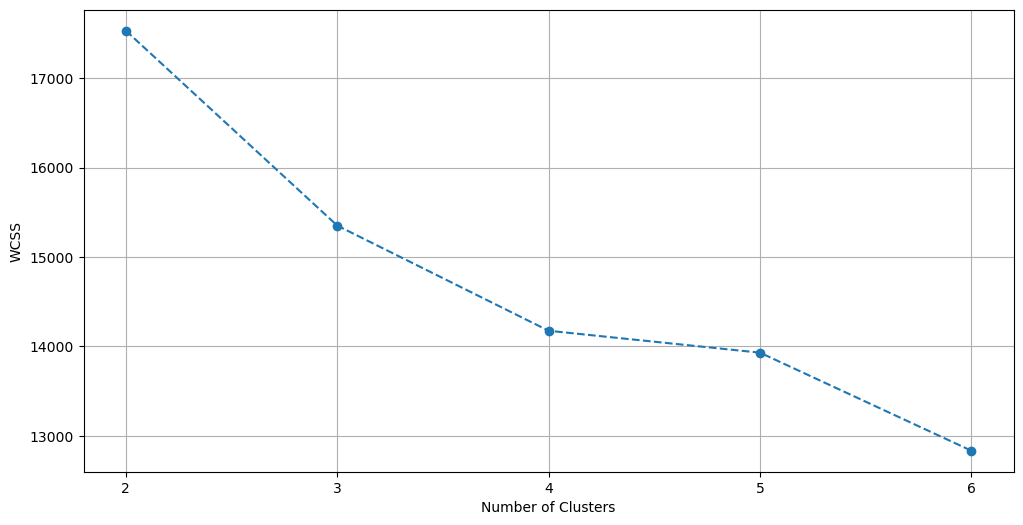

Determining optimal_k...
Optimal k is found to be 4
Training Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=4  14174.52053    0.259863          25.435446        1.871605   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=4        0.172247               14.91411            1.872173

Testing Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=4  14174.52053     0.18708           1.606406        1.315592   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=4        0.325801               3.377076            1.090727

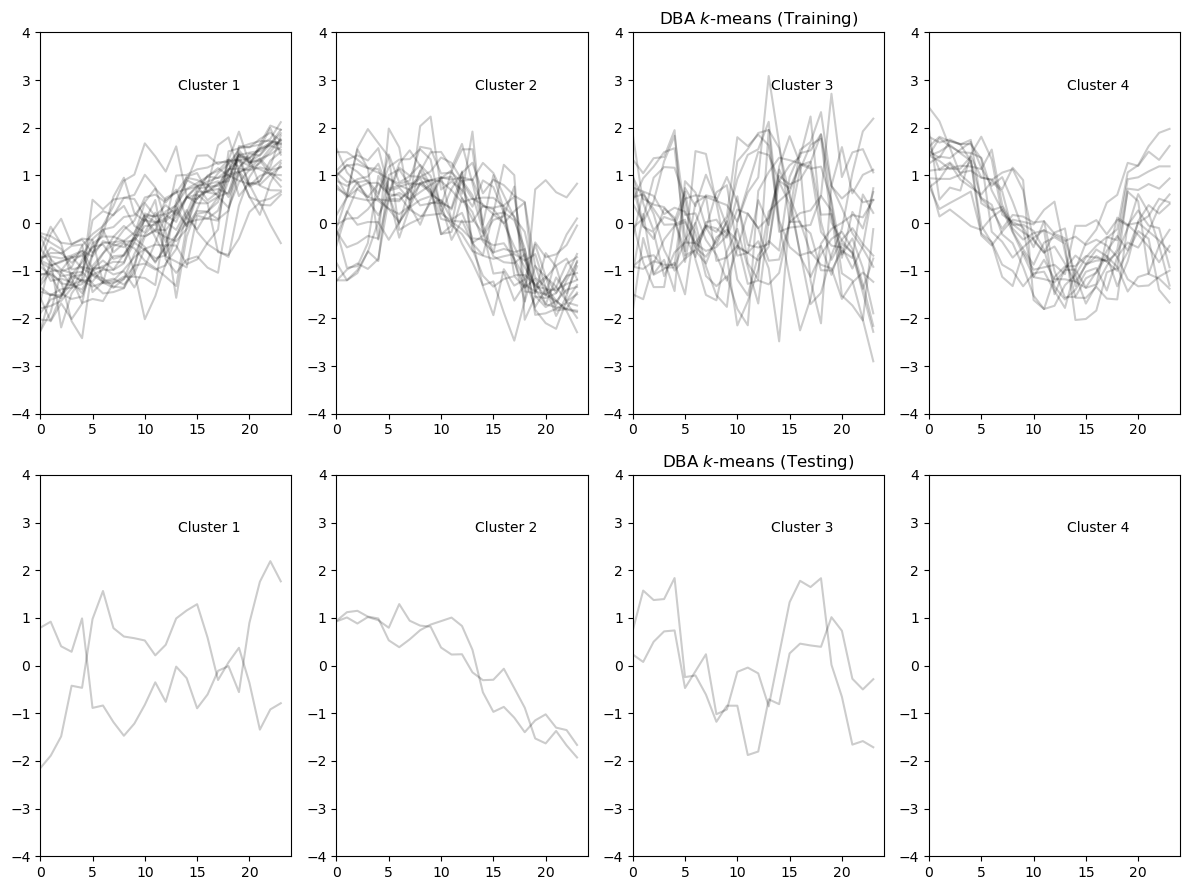

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  8.60it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                              1.0                       0.0   
1                                              1.0                       0.0   
2                                              0.0                       0.0   
3                                              1.0                       0.0   
4                                              0.0                       0.0   
..                                             ...                       ...   
73                                             1.0                       0.0   
74                                             0.0                       0.0   
75                                             1.0                       0.0   
76                                             0.0                       0.0   
77                                             0.0                       0.0   

    Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                        0.0                   0.0       5.018208e-13   
1                        0.0                   0.0      -8.615331e-14   
2                        0.0                   0.0       6.150636e-14   
3                        0.0                   0.0      -1.709743e-13   
4                        0.0                   0.0       1.256772e-13   
..                       ...                   ...                ...   
73                       0.0                   0.0       4.853895e-13   
74                       0.0                   0.0      -5.715428e-13   
75                       0.0                   0.0      -3.033129e-13   
76                       0.0                   0.0      -3.130829e-13   
77                       0.0                   0.0       4.440892e-16   

    Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0                24.0                0.621284           -0.117071   
1                24.0                0.592768           -0.033562   
2                24.0                0.484463           -0.010443   
3                24.0                0.302137           -0.068818   
4                24.0                0.247025            0.117478   
..                ...                     ...                 ...   
73               24.0                0.227151           -0.113128   
74               24.0                0.474234           -0.044379   
75               24.0                0.511423            0.042324   
76               24.0                0.468057            0.059283   
77               24.0                0.230265           -0.124036   

    Close__mean_second_derivative_central  Close__median  ...  \
0                               -0.010043       0.013040  ...   
1                                0.033783       0.024077  ...   
2                                0.011137       0.481173  ...   
3                                0.022547      -0.138479  ...   
4                               -0.001461      -0.464381  ...   
..                                    ...            ...  ...   
73                              -0.011214       0.457230  ...   
74                              -0.014185      -0.224917  ...   
75                              -0.012517      -0.187153  ...   
76                              -0.003001       0.293475  ...   
77                              -0.007623       0.234123  ...   

    Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                         1.072017                         1.285293   
1                         1.072017                         1.418069   
2                         0.687092                         1.178655   
3                         0.535961                         0.535961   
4                         0.271189                         0.535961   
..                             ...                              ...   
73                        0.535961                         

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.34it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             0.0                       0.0   
2                                             0.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   
5                                             0.0                       0.0   

   Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                       0.0                   0.0       7.904788e-14   
1                       0.0                   0.0       1.394440e-13   
2                       0.0                   0.0      -7.256418e-13   
3                       0.0                   0.0      -2.398082e-14   
4                       0.0                   1.0       4.440892e-16   
5                       0.0                   0.0       7.416290e-13   

   Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0               24.0                0.279414           -0.096743   
1               24.0                0.137773            0.121247   
2               24.0                0.504203            0.139814   
3               24.0                0.250941            0.127150   
4               24.0                0.413249            0.110330   
5               24.0                0.397261            0.123295   

   Close__mean_second_derivative_central  Close__median  ...  \
0                              -0.005585       0.134211  ...   
1                              -0.003016      -0.382016  ...   
2                               0.008562       0.091803  ...   
3                              -0.009858       0.460718  ...   
4                              -0.016155       0.081939  ...   
5                              -0.001317      -0.254585  ...   

   Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                        0.535961                         0.535961   
1                        0.271189                         0.535961   
2                        0.937156                         1.410514   
3                        0.793730                         0.793730   
4                        0.535961                         0.535961   
5                        0.830518                         1.303876   

   Close__fourier_entropy__bins_100  \
0                          1.178655   
1                          1.178655   
2                          2.351673   
3                          1.839297   
4                          1.732659   
5                          2.138397   

   Close__permutation_entropy__dimension_3__tau_1  \
0                                        1.657180   
1                                        0.838728   
2                                        1.567236   
3                                        1.606466   
4                                        1.538260   
5                                        1.540306   

   Close__permutation_entropy__dimension_4__tau_1  \
0                                        2.293452   
1                                        1.219137   
2                                        2.425480   
3                                        2.306336   
4                                        2.133211   
5                                        2.136507   

   Close__permutation_entropy__dimension_5__tau_1  \
0                                        2.718473   
1                                        1.607575   
2                                        2.787788   
3                                        2.649159   
4                                        2.622996   
5                                        2.510529   

   Close__permutation_entropy__dimension_6__tau_1  \
0                                        2.871476   
1                              

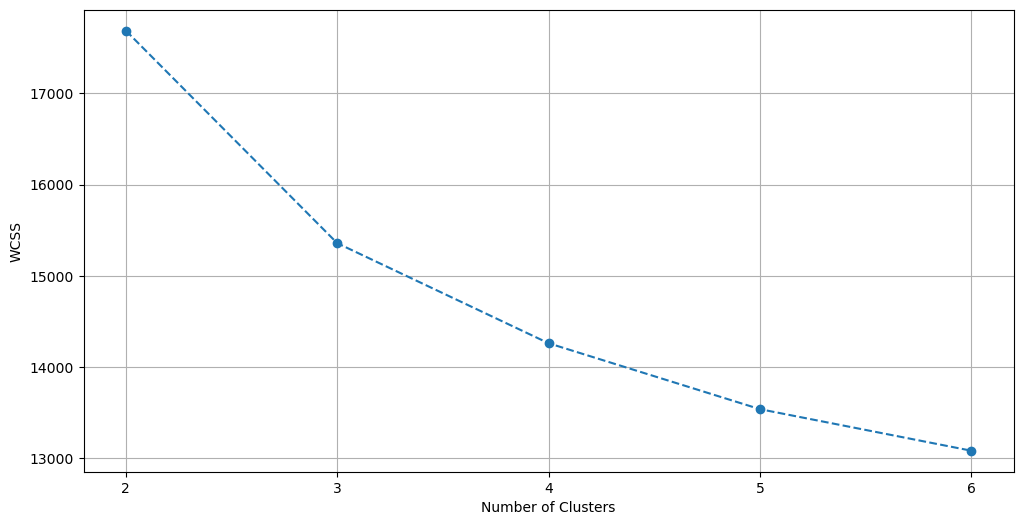

Determining optimal_k...
Optimal k is found to be 3
Training Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=3  15357.818168    0.294737          29.360258        1.927932   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=3        0.221596              17.879961            1.945203

Testing Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=3  15357.818168    0.136303           2.458493        1.336116   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=3        0.180749               2.608084            0.952198

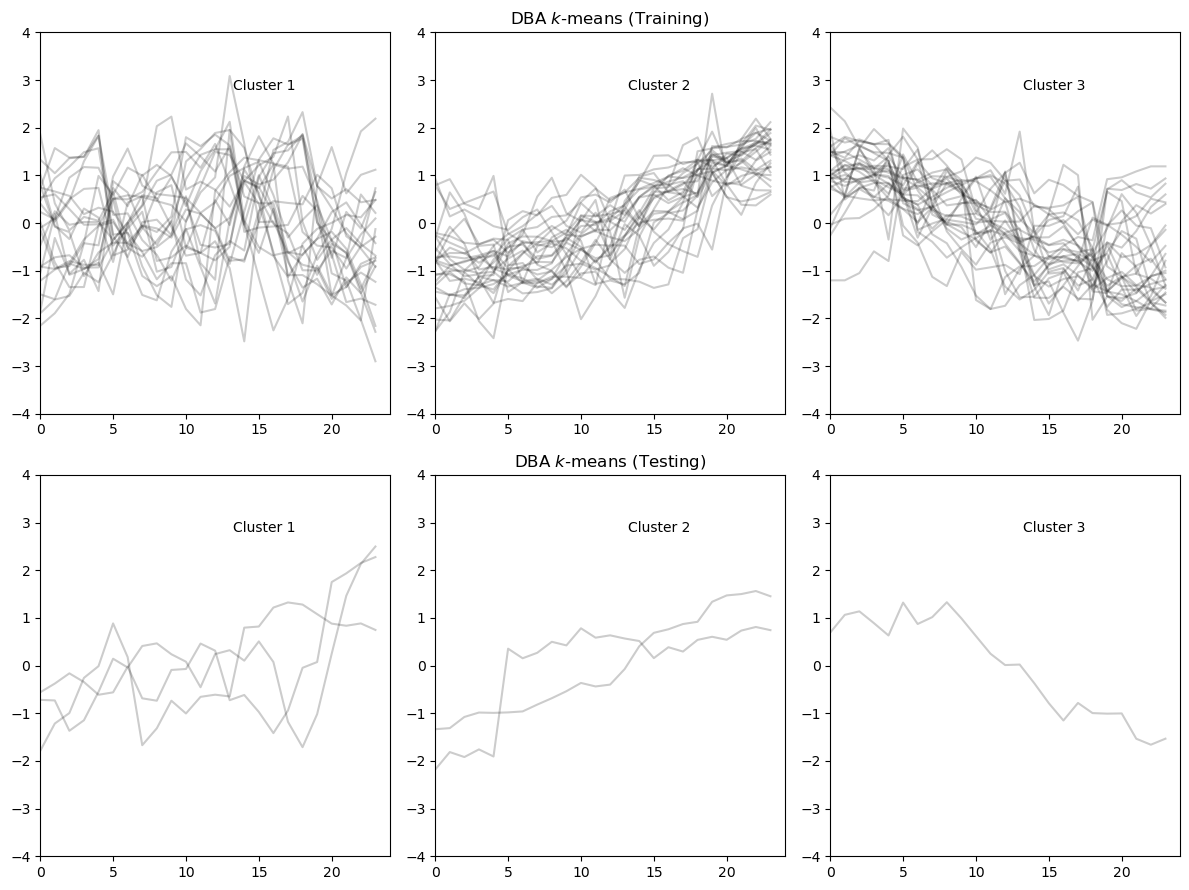

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 39/39 [00:04<00:00,  8.97it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                              1.0                       0.0   
1                                              1.0                       0.0   
2                                              0.0                       0.0   
3                                              1.0                       0.0   
4                                              0.0                       0.0   
..                                             ...                       ...   
73                                             0.0                       0.0   
74                                             0.0                       0.0   
75                                             0.0                       0.0   
76                                             0.0                       0.0   
77                                             0.0                       0.0   

    Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                        0.0                   0.0       1.896261e-13   
1                        0.0                   0.0       1.394440e-13   
2                        0.0                   0.0       3.246292e-13   
3                        0.0                   0.0      -1.743050e-13   
4                        0.0                   0.0      -3.641532e-14   
..                       ...                   ...                ...   
73                       0.0                   0.0       1.394440e-13   
74                       0.0                   0.0      -7.256418e-13   
75                       0.0                   0.0      -2.398082e-14   
76                       0.0                   1.0       4.440892e-16   
77                       0.0                   0.0       7.416290e-13   

    Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0                24.0                0.201673           -0.129051   
1                24.0                0.433708           -0.094681   
2                24.0                0.227536            0.122829   
3                24.0                0.323063           -0.068031   
4                24.0                0.222375            0.127096   
..                ...                     ...                 ...   
73               24.0                0.137773            0.121247   
74               24.0                0.504203            0.139814   
75               24.0                0.250941            0.127150   
76               24.0                0.413249            0.110330   
77               24.0                0.397261            0.123295   

    Close__mean_second_derivative_central  Close__median  ...  \
0                                0.002027       0.464347  ...   
1                               -0.014649       0.243460  ...   
2                                0.007731      -0.468421  ...   
3                               -0.000576      -0.196351  ...   
4                               -0.003530       0.309669  ...   
..                                    ...            ...  ...   
73                              -0.003016      -0.382016  ...   
74                               0.008562       0.091803  ...   
75                              -0.009858       0.460718  ...   
76                              -0.016155       0.081939  ...   
77                              -0.001317      -0.254585  ...   

    Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                         0.535961                         0.793730   
1                         0.687092                         0.937156   
2                         0.687092                         1.043794   
3                         0.535961                         0.535961   
4                         0.271189                         0.687092   
..                             ...                              ...   
73                        0.271189                         

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.80it/s]


Close__variance_larger_than_standard_deviation  Close__has_duplicate_max  \
0                                             0.0                       0.0   
1                                             0.0                       0.0   
2                                             1.0                       0.0   
3                                             0.0                       0.0   
4                                             0.0                       0.0   
5                                             1.0                       0.0   

   Close__has_duplicate_min  Close__has_duplicate  Close__sum_values  \
0                       0.0                   0.0       6.568079e-13   
1                       0.0                   0.0      -2.255973e-13   
2                       0.0                   0.0      -2.547962e-13   
3                       0.0                   0.0       2.429390e-12   
4                       0.0                   0.0      -2.158274e-13   
5                       0.0                   0.0       6.785683e-13   

   Close__abs_energy  Close__mean_abs_change  Close__mean_change  \
0               24.0                0.362205            0.148735   
1               24.0                0.162353            0.109294   
2               24.0                0.556319            0.040252   
3               24.0                0.494184            0.019648   
4               24.0                0.532661           -0.101884   
5               24.0                0.412636            0.152559   

   Close__mean_second_derivative_central  Close__median  ...  \
0                              -0.012228      -0.350958  ...   
1                               0.000665      -0.239022  ...   
2                               0.001525       0.161798  ...   
3                              -0.004418      -0.065238  ...   
4                               0.002404      -0.072318  ...   
5                              -0.005118       0.077436  ...   

   Close__fourier_entropy__bins_5  Close__fourier_entropy__bins_10  \
0                        0.793730                         1.043794   
1                        0.535961                         0.535961   
2                        0.687092                         1.263626   
3                        0.793730                         1.043794   
4                        0.535961                         1.118969   
5                        1.303876                         1.732659   

   Close__fourier_entropy__bins_100  \
0                          2.204785   
1                          1.410514   
2                          2.351673   
3                          2.098147   
4                          2.098147   
5                          2.031759   

   Close__permutation_entropy__dimension_3__tau_1  \
0                                        1.492738   
1                                        1.222602   
2                                        1.562044   
3                                        1.684924   
4                                        1.684924   
5                                        1.555751   

   Close__permutation_entropy__dimension_4__tau_1  \
0                                        2.309633   
1                                        1.656454   
2                                        2.595309   
3                                        2.516410   
4                                        2.598605   
5                                        2.238941   

   Close__permutation_entropy__dimension_5__tau_1  \
0                                        2.692311   
1                                        2.094641   
2                                        2.857103   
3                                        2.857103   
4                                        2.857103   
5                                        2.553682   

   Close__permutation_entropy__dimension_6__tau_1  \
0                                        2.798513   
1                              

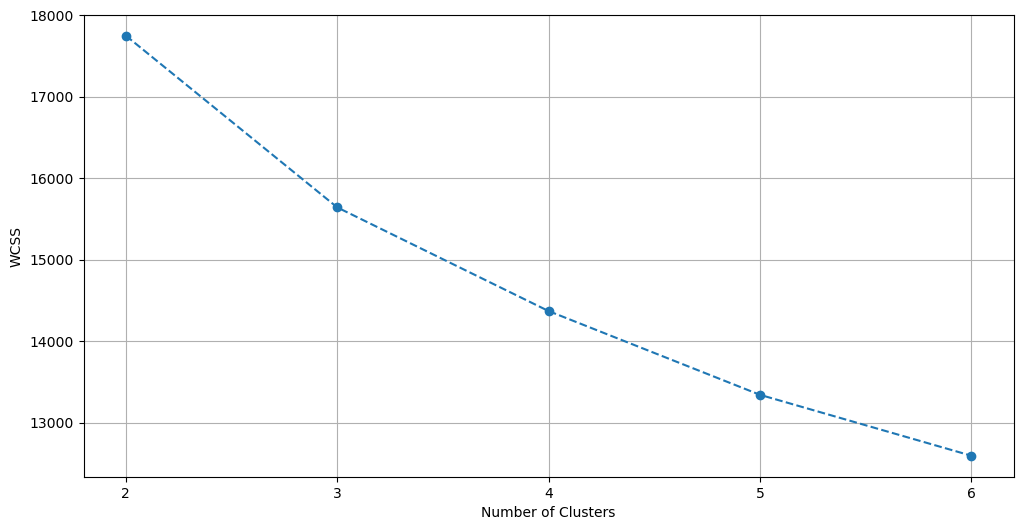

Determining optimal_k...
Optimal k is found to be 3
Training Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=3  15640.497922    0.282946          29.914645        1.859044   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=3        0.236248              17.118766            1.948236

Testing Results


wcss  silhouette  calinski_harabasz  davies_bouldin  \
k=3  15640.497922    0.421603           2.398016        1.068603   

     silhouette_pca  calinski_harabasz_pca  davies_bouldin_pca  
k=3        0.213203               2.542504            0.790614

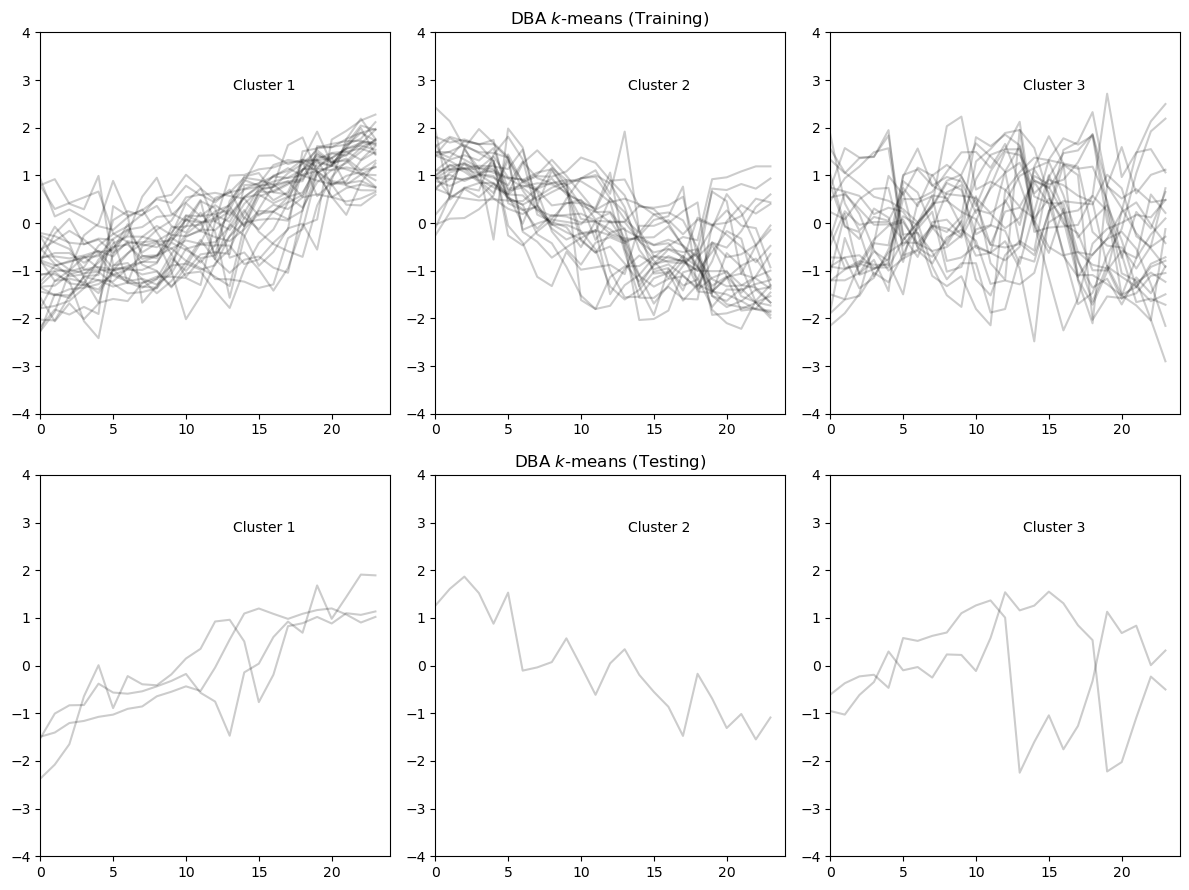

In [98]:
point8_comp_pred_results = generate_train_test_split_results(df, n_components=0.8)

### Plot cluster results in subplots

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

color_palette = px.colors.qualitative.Safe

def plot_clusters(df, index, y_pred, fig, row, col, cluster_legends):    
    X_df = df.loc[index]
    # Plot background 
    fig.add_trace(go.Scatter(y=X_df.Close, x=X_df.Datetime, mode="lines", line_color='lightgrey', showlegend=False), row=row, col=col)
    
    X_df.set_index("Datetime", inplace = True)
    X_group_df = X_df.groupby(pd.Grouper(freq='W'))
    
    # Retrieve indices of clusters labelled, starting with 0
    for cluster_label in np.unique(y_pred):
        grp_indices = np.where(y_pred == cluster_label)[0]
        # Iterate through each group and add it as trace
        grp_keys = list(X_group_df.groups.keys())
        for i, grp_idx in enumerate(grp_indices):
            X_sub_df = X_group_df.get_group(grp_keys[grp_idx])
            X_sub_df.reset_index(inplace=True)
            if i == 0 and cluster_label not in cluster_legends:
                # Check if trace is the first of its legend group
                fig.add_trace(go.Scatter(y=X_sub_df.Close, x=X_sub_df.Datetime, mode="lines", line_color=color_palette[cluster_label], legendgroup=f"Cluster_{cluster_label+1}", name=f"Cluster_{cluster_label+1}"), row=row, col=col)
                cluster_legends.append(cluster_label)
            else:
                fig.add_trace(go.Scatter(y=X_sub_df.Close, x=X_sub_df.Datetime, mode="lines", line_color=color_palette[cluster_label], legendgroup=f"Cluster_{cluster_label+1}", showlegend=False), row=row, col=col)
    
    
def plot_clustering_predictions_subplots(df, pred_results):
    df = df.reset_index()
    count = 1
    cluster_legends = []
    # subplot setup
    fig = make_subplots(rows=len(pred_results), cols=1, shared_xaxes=True, vertical_spacing=0.05,
                        subplot_titles=[f"Train_Test_Clustering Plot {x} ({len(np.unique(pred_results[x - 1][0]))} Clusters)" for x in range(1, len(pred_results)+1)])

    for train_index, test_index in tscv.split(df, date_column='Datetime'):
        y_pred_train, y_pred_test = pred_results[count - 1]
        print(f"y_pred_train: {y_pred_train}")
        print(f"y_pred_test: {y_pred_test}")

    #     fig = go.Figure()
        plot_clusters(df, train_index, y_pred_train, fig, count, 1, cluster_legends)

        # Add rect and line to split train and test set
        fig.add_vrect(x0=(df.loc[train_index].iat[0,0] - relativedelta(days=1)).timestamp() * 1000, x1=df.loc[test_index].iat[0,0].timestamp() * 1000, 
                  annotation_text="training_set", annotation_position="top left",
    #               annotation=dict(font_size=20, font_family="Times New Roman"),
                  fillcolor="orange", opacity=0.1, line_width=0, row=count, col=1)
        fig.add_vrect(x0=df.loc[test_index].iat[0,0].timestamp() * 1000, x1=df.loc[test_index].iat[-1,0].timestamp() * 1000, 
              annotation_text="testing_set", annotation_position="top left",
    #               annotation=dict(font_size=20, font_family="Times New Roman"),
              fillcolor="green", opacity=0.1, line_width=0, row=count, col=1)
        fig.add_vline(x=df.loc[test_index].iat[0,0].timestamp() * 1000, annotation_text="train_test_split", annotation_position="bottom left", annotation_textangle = -90, line_width=2, line_dash="dash", line_color="grey", row=count, col=1)

        plot_clusters(df, test_index, y_pred_test, fig, count, 1, cluster_legends)
        count += 1

    fig.update_layout(
        plot_bgcolor='white',
        title=f"Train_Test_Clustering Plots",
        height=1500,
    #     width=600,
    )

    fig.update_xaxes(
            mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        gridcolor='lightgrey',
        range=[start, end],
        rangebreaks=[
            dict(values=[x for x in list(nyse_holidays.keys()) if x.weekday() != 4]),  # hide NYSE holidays excluding those that fall on a Friday. 
            # Plotly rangebreaks bug makes them overlap
            dict(bounds=["sat", "mon"]), #hide weekends
            dict(bounds=[16, 9.5], pattern="hour"), #hide hours outside of 9am-5pm
        ],
    )

    fig.update_yaxes(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='black',
        gridcolor='lightgrey'
    )
    # Enable autoscale for x-axis
    fig['layout']['xaxis'].update(autorange = True)

    fig.show()

In [ ]:
plot_clustering_predictions_subplots(df, three_comp_pred_results)

In [ ]:
plot_clustering_predictions_subplots(df, point8_comp_optimal_k_pred_results)

### Additional Analysis: Differenced Dataset (Returns) 